<a href="https://colab.research.google.com/github/kevalshah90/token-classification-fine-tuning/blob/main/RevRE_textClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fine-tuning an LLMs for Real Estate Financial statements text classification task


Problem statement:

A T12 is a financial statement that breaks down income and expenses of the real estate property over the past twelve months. Each line item is categorized as either income or expense. These reports can typically be obtained from PMSs (Property Management systems). Different PMSs may use slightly different structure / reporting formats. Thus, semantically similar line items may be worded differently. Additionally, T12s could also include multi-level hierarchy which has useful information. This makes it challenging to create standardized reporting across different systems.

Proposed solution:

Depending on the required complexity, availability of data and considerations for compute costs, we outline 3 different approaches (ordered by complexity). Each of them have some pros and cons:

Train a ML classifier (eg. Random forest classifier)
BERT
LLMs (eg. llama)


We have already trained a random forest classifier and have experimented with different parameters to improve accuracy.


**BERT** relies on a Transformer (the attention mechanism that learns contextual relationships between words in a text). A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The input to the encoder for BERT is a sequence of tokens, which are first converted into vectors and then processed in the neural network. But before processing can start, BERT needs the input to be massaged and decorated with some extra metadata:

Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.

Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.

Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.

**Input:**

Sentence: Consider the sentence: "The quick brown fox jumps over the lazy dog."

Tokenization: BERT first breaks down the sentence into individual words (tokens). These tokens become: ['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']

Special Tokens: BERT adds special tokens to provide context:

[CLS]: Classification token inserted at the beginning (often used for tasks like sentence classification).
[SEP]: Separator token inserted at the end to differentiate between multiple sentences as input. The final input becomes: ['[CLS]', 'The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.', '[SEP]']

Word Embeddings: Each token is converted into a numerical representation called a word embedding. These capture the meaning and relationships between words.

**Output:**

Contextualized Embeddings: BERT processes the entire sentence with its attention mechanism, considering how words relate to each other.

For each token: BERT generates a contextualized embedding of fixed 768 dimension. This embedding reflects the word's meaning based on its surrounding context in the sentence.

BERT seems like a good option for text classification given that it is trained on general text data corpus and may capture the context from the hierarchical structure. Since, our goal is text classification BERTs encoder-only architecture would work well for us. Depending on different evaluation metrics from BERT, we can decide if LLMs are worth a shot.

Reference: 

- https://arxiv.org/abs/1810.04805

- https://github.com/google-research/bert

- https://osanseviero.github.io/hackerllama/blog/posts/random_transformer/

- https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270

- https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

- https://github.com/huggingface/blog/blob/main/Lora-for-sequence-classification-with-Roberta-Llama-Mistral.md

- https://huggingface.co/docs/peft/v0.6.2/en/task_guides/token-classification-lora

In [ ]:
# !pip install torch
# !pip install transformers
# !pip install datasets
# !pip install spacy_annotator
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [1]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/token-classification-fine-tuning'

In [2]:
files = !ls
files

['bert.png',
 'df_nlp_fin.csv',
 'model',
 'output1.csv',
 'README.md',
 'requirements.txt',
 'RevRE_textClassification.ipynb',
 'RevRE-textClassification.ipynb']

In [3]:
if 'requirements.txt' in files:
    !pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 913.0 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 128.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 851.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.8 MB/s eta 0:00:00:00:

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 913.0 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 128.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 851.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 15.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━

In [3]:
#!pip install --upgrade pandas
#!pip install --upgrade datasets

In [3]:
import os
import numpy as np
from sklearn import metrics
import pandas as pd
import seaborn as sns
import torch
import transformers
from torch.utils.data import Dataset, DataLoader#, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, BertTokenizer, BertModel, BertConfig, DistilBertTokenizer, \
DistilBertModel, pipeline, DataCollatorWithPadding, AutoModelForSequenceClassification

from datasets import load_dataset

# NER Annotation
#import spacy
#import spacy_annotator as spacy_anot

In [4]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


In [5]:
# read csv
df = pd.read_csv("output1.csv", on_bad_lines="skip")
df[['Header','INCOME','Income']].sample(10)

,Header,INCOME,Income
2044,Less: Technology Allocation,Property Management Software,Expense
2162,Total,Net Operating Income,Expense
1823,Header,EXPENSES,Expense
1350,Total,NET INCOME,Expense
501,Total,Total Operating Income,Income
1964,Gain / Loss to Lease,Gain / (Loss) To Lease,Income
1546,Less: Meals and Entertainment,Meals - Non Travel,Expense
761,Less: Repair Costs,JOB - Parking Lot Resurfacing/Paving,Expense
1249,Less: Other Contract Services,Resident Screening,Expense
2048,Less: Other Contract Services,Property Inspections,Expense


In [6]:
# Format data such that we have 2 columns text and label
df['texts'] = df['Header'] + " " + df['INCOME']
df.rename(columns={'Income':'label'}, inplace=True)

# subset dataframe with required columns only
df1 = df[['texts','label']]
df1.sample(10)

,texts,label
1723,NaN,Expense
1969,"Less: Office, Model, Down Units Model/Office",Income
2051,Less: Office Expenses Business Center Expense,Expense
2067,Less: Marketing Marketing Software,Expense
1113,Less: Leasing Agent Salary Leasing Salaries,Expense
1761,NaN,Expense
333,Less: Repair Costs Appliances,Expense
1114,Less: Bonuses and Commissions Leasing Bonuses,Expense
1315,Total NET OPERATING INCOME,Expense
741,Less: Capital Improvements CAP- Kitchen,Expense


<Axes: xlabel='label', ylabel='Count'>

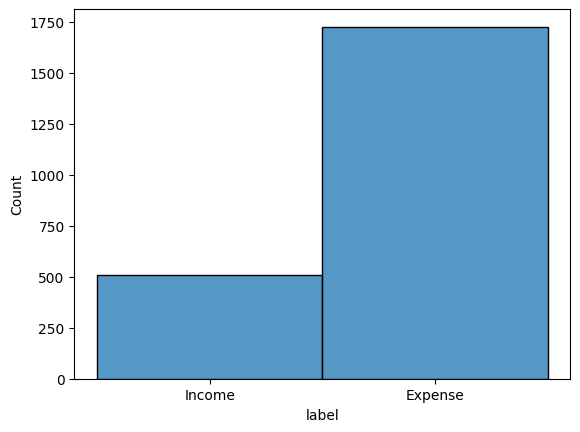

In [7]:
sns.histplot(df1, x='label')

In [8]:
df1.shape

(2234, 2)

#### BERT Pre-Training: Tokenization

As a first step, we need to transform this sentence into a sequence of tokens (words) and this process is called tokenization.

BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

[CLS]: This is the first token of every sequence, which stands for classification token.

[SEP]: This is the token that makes BERT know which token belongs to which sequence.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.

For a text classification task, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

<img src="https://github.com/kevalshah90/token-classification-fine-tuning/blob/main/bert.png?raw=1" width="500px" height="500px">

Conceptual example:

In [11]:
# Let's define a tokenizer and see how it works with example text, before applying it on our dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Download model weights and configuration from huggingface.co and cache.
model = BertModel.from_pretrained("bert-base-uncased")

# save model
folder = os.getcwd() + '/model'
model.save_pretrained(folder)
tokenizer.save_pretrained(folder)

# Load model from local directory
model = BertModel.from_pretrained(folder)
tokenizer = BertTokenizer.from_pretrained(folder)

text = "I will watch Memento tonight"

bert_input = tokenizer(
                       text,
                       padding='max_length',
                       max_length = 10,
                       truncation=True,
                       return_tensors='pt'
                      )

print(f'raw bert input: {bert_input}')

raw bert input: {'input_ids': tensor([[  101,  1045,  2097,  3422,  2033, 23065,  3892,   102,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])}


**BERT Tokenizer output -> BERT model input**

1. input_ids:

This is a tensor containing integer IDs that represent the tokens in the sentence. Each ID corresponds to a specific word or punctuation mark based on the tokenizer's vocabulary.

2. token_type_ids:

This tensor is used by some BERT models (especially when processing two sentences together) to distinguish between the tokens from the first and second sentence.

In your example: `tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])`: All zeros indicate that this is likely processing a single sentence, and there's no need to differentiate between token types.

3. attention_mask:

This tensor is crucial for BERT to focus on relevant parts of the input sequence.

It's a binary mask where:

1: Represents a valid token that BERT should attend to (consider) during its processing.

0: Represents padding (usually added for sequences shorter than a maximum length) or special tokens (like [CLS] or [SEP]) that BERT might handle differently depending on the model architecture.

In your example:

`tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])`: The first eight elements are 1, indicating these are valid tokens. The last two elements are 0, likely representing padding tokens added by the tokenizer since the sentence might be shorter than the maximum sequence length the model can handle.

We can actually decode the `input ids` into the actual tokens.

In [12]:
decoded_text = tokenizer.decode(bert_input.input_ids[0])
print(decoded_text)

[CLS] i will watch memento tonight [SEP] [PAD] [PAD]


The second row is the `attention_mask`, which is a binary mask that identifies whether a token is a real word or just padding. If the token contains [CLS], [SEP], or any real word, then the mask would be 1. Meanwhile, if the token is just padding or [PAD], then the mask would be 0.

In [14]:
# The double-asterisk syntax (**) is used for dictionary unpacking in Python.
# For example, if inputs is {'input_ids': ..., 'attention_mask': ...}, then model(**inputs) is equivalent to model(input_ids=..., attention_mask=...).

# Docs: https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
output = model(**bert_input)
print(output.last_hidden_state)

tensor([[[ 0.2525,  0.1361,  0.3508,  ..., -0.0583,  0.1160,  0.0485],
         [ 0.7061, -0.3370,  0.8233,  ..., -0.0267,  0.3706,  0.2705],
         [ 0.7614, -0.3710,  0.7189,  ..., -0.1834, -0.1090, -0.4638],
         ...,
         [ 0.7152,  0.1961,  0.0433,  ...,  0.0018, -0.7089, -0.4705],
         [ 0.0168, -0.0343,  0.8173,  ...,  0.1860,  0.0395, -0.0309],
         [-0.2035, -0.0342,  0.7162,  ...,  0.5625,  0.1891, -0.2875]]],
       grad_fn=<NativeLayerNormBackward0>)


In [16]:
output.last_hidden_state.shape

torch.Size([1, 10, 768])

**Bert model output**

A contextualized embedding vector of `768`-dimension, typically the last hidden layer, generated for each token in the input sentence.

BERT Embeddings: BERT builds upon pre-trained word embeddings, which capture the meaning of individual words. These word embeddings are typically much lower dimensional (e.g., 300).

Contextualization: BERT goes beyond basic word embeddings by incorporating contextual information. It considers the entire sentence and the relationships between words using its encoder layers and attention mechanism.

Higher Dimensionality: The 768 dimension in the contextualized embedding allows BERT to capture a richer and more nuanced representation of a word's meaning based on the surrounding context. This additional dimension compared to word embeddings enables BERT to model these complex contextual relationships.

**Data pre-processing, Dataset and DataLoader from pytorch.data.utils**

Let's write a class to tokenize our data and generate necessary outputs for the BERT model. This class defines how the text is pre-processed before sending it to the neural network.

The *Dataset* and *DataLoader* classes provide a mechanism to load data efficiently in batches during training.

pytorch allows for parallel processing using multiple CPU cores or GPUs. **DataLoader helps in parallelizing data** loading, enabling the model to process multiple batches simultaneously.

The **Dataset class allows you to define custom transformations** on the input data, such as resizing images, normalizing pixel values, or tokenizing text. These transformations are applied on-the-fly during data loading.

DataLoader handles the process of grouping samples into batches, making it easier to feed batches of data to the model during training.

In [17]:
max_length = 100

In [18]:
# define a dict to encode labels
labels = {
          'Expense': 0,
          'Income': 1
         }

In [26]:
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class customDataset(Dataset):

    # initialize the attributes or properties of an object.
    def __init__(self, dataframe, tokenizer, max_len):

        self.data = dataframe
        self.tokenizer = tokenizer
        self.texts = dataframe.texts
        self.labels = [labels[l] for l in df1['label']]
        self.max_len = max_length

    """
    necessary for DataLoader class batching, determine the total number of batches in an epoch and for initializing the DataLoader.
    """

    def __len__(self):
        return len(self.texts)

    """
    This method retrieves a single sample from the dataset at the given index idx.
    It enables you to index into the dataset using square brackets ([]).
    In the context of training, this method is used by the DataLoader to retrieve individual samples during iteration.
    """

    def __getitem__(self, index):

        texts = str(self.texts[index])
        texts = " ".join(texts.split())
        #print('get item texts -', texts)

        inputs = self.tokenizer(
                                texts,
                                add_special_tokens=True,
                                padding='max_length',
                                max_length = max_length,
                                truncation=True,
                                return_tensors='pt'
                               )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
                'ids': ids,
                'mask': mask,
                'labels': self.labels[index]
        }

In [27]:
train_size = 0.8 # 80% training data

# sample training data
train_df = df1.sample(frac=0.8, random_state=200)
# Test data
test_df = df1.drop(train_df.index).reset_index(drop=True)
# reset index
train_df.reset_index(drop=True, inplace=True)

print("Original Dataset {}".format(df1.shape))
print("Training Dataset {}".format(train_df.shape))
print("Test Dataset {}".format(test_df.shape))

Original Dataset (2234, 2)
Training Dataset (1787, 2)
Test Dataset (447, 2)


In [28]:
# Initialize the class
train_data = customDataset(train_df, tokenizer, max_length)
test_data = customDataset(test_df, tokenizer, max_length)

In [33]:
for i,n in enumerate(train_data):
    print(i, n)
    if i == 5:
        break

0 {'ids': tensor([[  101,  4606,  1024, 28616,  2278,  1012,  2060,  3318,  4807,  3578,
          9278,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 

In [ ]:
# save file
df1.to_csv('df_nlp_fin.csv')

In [23]:
# Parallelize batch loading using pytorch DataLoader class

# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4

train_params = {
                'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {
                'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(train_data, **train_params)
testing_loader = DataLoader(test_data, **test_params)

In [25]:
training_loader.batch_size

8

### Creating the Neural Network for fine-tuning

**Neural Network**

- We will be creating a neural network with the BERTClass.
- This network will have the Bert model. Followed by a Dropout and Linear Layer. They are added for the purpose of Regulariaztion and Classification respectively.
- In the forward loop, there are 2 output from the BertModel layer.
- The second output `output_1` or called the pooled output is passed to the Drop Out layer and the subsequent output is given to the Linear layer.
- Keep note the number of dimensions for Linear Layer is 2 because that is the total number of categories in which we are looking to classify our model.
- The data will be fed to the BertClass as defined in the dataset.
- Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction.
- We will initiate an instance of the network called model. This instance will be used for training and then to save the final trained model for future inference.

> More on **dropout layer**:

- Dropout is a regularization technique designed to prevent overfitting in neural networks during training. Overfitting occurs when a model learns to perform well on the training data but fails to generalize to new, unseen data.

- During each forward pass in training, individual neurons (or units) in the dropout layer are "dropped out" with a certain probability. This means their output is set to zero. The output of DistilBERT (output_1) in this model.

- nn.Dropout(0.3) refers to the probability of an input unit being zeroed out during each training step.

> More on **linear layer**:

- The linear layer (also known as the dense layer or fully connected layer) is responsible for transforming input features into output features through linear transformation.


- Each neuron in the linear layer is connected to every neuron in the previous layer, forming a fully connected structure. The output of each neuron is the weighted sum of its inputs plus a bias term.


- The linear transformation is defined by a weight matrix and a bias vector. If the input has size input_size and the output has size output_size, the weight matrix is of shape (output_size, input_size).

- Activation Function: After the linear transformation, an activation function (e.g., ReLU, sigmoid, softmax) is often applied element-wise to introduce non-linearity to the model. The activation function allows the network to capture more complex relationships in the data.

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.
from torch import nn

"""
`BERTClass(torch.nn.Module)` Inherit from `nn.Module`, the base class for all PyTorch neural network modules.

1. __init__:

    Call constructor `__init__` method of the superclass nn.module before initializing the subclass BERTClass.

    Applies dropout regularization to the output of BERT.

    Linear layer for classification with input size 768 (BERT hidden size) and output size 2 (number of classes).

    Sigmoid activation function, an S-shaped function to map an input value to probabilities between 0 and 1.

2. Forward pass

    _, pooler_output = self.bert(ids, attention_mask = mask, return_dict=False) 
    > Forward pass through the BERT model, taking input IDs (input_id) and attention mask (mask). 
    It returns both the last layer hidden states (denoted by _) and the pooled output (representing the entire input sequence).

    Apply dropout to the pooled output.
    > Dropout is a technique used to prevent overfitting by randomly dropping out a certain percentage of neurons during training.

    Passes the dropout output through a linear layer for classification.
    > This linear layer transforms the 768-dimensional BERT output into a 1-dimensional output representing the logits 
    (unnormalized probabilities) for the classification task.

    Applies the Sigmoid activation function to the linear output.
    > This line applies the sigmoid activation function to the linear output. 
    The sigmoid function maps the logits between 0 and 1 (normalized probabilities) for the binary classification.
    
"""

# Docs: https://pytorch.org/docs/stable/nn.html
class BERTClass(torch.nn.Module):

    def __init__(self):
        super(BERTClass, self).__init__() 
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3) 
        self.linear = nn.Linear(768, 1) 
        self.sigmoid = nn.Sigmoid() 

    def forward(self, ids, mask):

        _, pooler_output = self.bert(ids, attention_mask = mask, return_dict=False) # Forward pass through the BERT model, taking input IDs (input_id) and attention mask (mask). It returns both the last layer hidden states (denoted by _) and the pooled output (representing the entire input sequence).

        dropout_output = self.dropout(pooler_output) # Applies dropout to the pooled output.
        linear_output = self.linear(dropout_output) # Passes the dropout output through a linear layer for classification.
        final_layer = self.sigmoid(linear_output) # Applies the Sigmoid activation function to the linear output.

        return final_layer

bmodel = BERTClass()
bmodel.to(device)

BERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

### Loss Function and Optimizer

- The Loss is defined in the next cell as loss_fn.
- As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as BCELogits Loss in PyTorch
- Optimizer is defined in the next cell.
- Optimizer is used to update the weights of the neural network to improve its performance.

#### Further Reading

- You can refer to my [Pytorch Tutorials](https://github.com/abhimishra91/pytorch-tutorials) to get an intuition of Loss Function and Optimizer.
- [Pytorch Documentation for Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Pytorch Documentation for Optimizer](https://pytorch.org/docs/stable/optim.html)
- Refer to the links provided on the top of the notebook to read more about `BertModel`.

In [40]:
LEARNING_RATE = 1e-05

In [ ]:
def loss_fn(outputs, targets):

    return torch.nn.BCELoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  bmodel.parameters(), lr=LEARNING_RATE)

### Fine Tuning the model

`train(epoch)` defines the training loop for a neural network model using PyTorch. 

Here's a detailed breakdown of what each part does:

Function Purpose:

This function trains the model (bmodel) on a given epoch (epoch) of the training data.

Steps:

1. Set Model to Train Mode:

`bmodel.train()`: This line sets the model to training mode. This might activate dropout layers or other functionalities specific to the training process.

2. Iterate Through Training Data:

for _, data in enumerate(training_loader, 0): This line iterates through the training data loader (training_loader).

_: This underscore variable is a placeholder and is typically not used within the loop.

data: This variable represents a batch of training data retrieved from the data loader. It's usually a dictionary containing various elements like input IDs, attention mask, and labels.

3. Process Labels:

labels = data['labels'].to(device, dtype = torch.float).unsqueeze(1): This line processes the labels (data['labels']) from the data batch:
Converts them to the device and float data type (torch.float) assuming labels are continuous values (e.g., sentiment scores).
Uses unsqueeze(1) to insert a new dimension at index 1. This might be necessary depending on the expected input format for the loss function.
Reshape Input Data (if necessary):

ids = ids.view(-1, ids.size(-1)): This line reshapes the input IDs (ids) if needed. The view function allows reshaping the tensor. Here, -1 in the first dimension infers the size based on the other dimensions, and ids.size(-1) keeps the last dimension intact (usually the sequence length).
mask = mask.view(-1, mask.size(-1)): This line performs similar reshaping for the attention mask (mask) if necessary.
Model Forward Pass:

outputs = bmodel(ids, mask): This line performs the forward pass of the model (bmodel). It feeds the input IDs (ids) and attention mask (mask) into the model and retrieves the model's output (outputs). These outputs might be logits (unnormalized probabilities) or other task-specific predictions.

4. Calculate Loss:

loss = loss_fn(outputs, labels): This line calculates the loss between the model's output (outputs) and the ground-truth labels (labels). The specific loss function (loss_fn) depends on the task (e.g., cross-entropy loss for classification).
Print Loss (Optional):

5. if _%100==0:: This conditional block executes every 100th iteration.
print('itr',_): Prints the current iteration number (again, not very informative).
print(f'Epoch: {epoch}, Loss: {loss.item()}'): Prints the current epoch number (epoch) and the calculated loss value (loss.item()) as a floating-point number.

6. Backpropagation and Optimization:

optimizer.zero_grad(): This line zeros out the gradients from the previous iteration before accumulating new gradients for the current batch.
loss.backward(): This line performs backpropagation. It calculates the gradients of the loss function with respect to the model's parameters.
optimizer.step(): This line updates the model's parameters using the optimizer (optimizer) and the


The three lines at the bottom of the `training` function represent the core training loop steps within a neural network using PyTorch:

`optimizer.zero_grad() (Clears Gradients):`

This line is crucial for efficient training. In neural networks, the gradients represent how much each parameter (weight and bias) in the model contributed to the overall error (loss) during the previous training iteration.
Calling optimizer.zero_grad() explicitly sets all the gradients to zero before starting a new iteration. 
This ensures that gradients from the current iteration are accumulated accurately without being influenced by the previous ones.

`loss.backward() (Backpropagation):`

This line performs backpropagation, a vital algorithm for training neural networks. Backpropagation efficiently calculates the gradients of the loss function with respect to each parameter in the model.

It works by:
    
1. Starting from the output layer and propagating the error backward through the network layer by layer.

2. Utilizing the chain rule of differentiation to calculate the gradients for each layer's weights and biases.
                                                                        
3. The calculated gradients provide essential information on how to adjust the model's parameters in the right direction to minimize the loss on future data.
optimizer.step() 
                                                                         
(Parameter Update):

This line performs the parameter update step using the chosen optimizer (optimizer).
                                                                         
The optimizer utilizes the gradients calculated by backpropagation (loss.backward()) to update the weights and biases of the model.
                                                                         
The goal of this update is to minimize the loss function and improve the models performance on future data.

Different optimizers use various algorithms to update the parameters, with some popular choices including:

Stochastic Gradient Descent (SGD): A fundamental optimizer that updates weights in the direction opposite their gradients, with a learning rate controlling the step size.

Momentum: An extension of SGD that considers past gradients, accelerating convergence.

Adam (Adaptive Moment Estimation): A popular optimizer that dynamically adjusts the learning rate for each parameter based on historical gradients.


Working Together:

These three steps work in a loop during training:

A batch of data is fed through the network (forward pass).
                                                                                                 
The loss is calculated based on the model's output and the ground-truth labels.
                                                                                                 
optimizer.zero_grad() clears gradients from the previous iteration.
                                                                                                 
loss.backward() performs backpropagation to calculate gradients for each parameter.
                                                                                                 
optimizer.step() uses the gradients to update the model's weights and biases.
                                                                                                 
Steps 1-5 are repeated for multiple epochs (iterations over the entire training data) to gradually refine the model's performance.
In essence:

Backpropagation calculates how each parameter affects the loss.
             
The optimizer uses this information to adjust the parameters and steer the model towards better predictions.
             
Clearing gradients (optimizer.zero_grad()) ensures clean accumulation of gradients in each iteration for efficient training.
"""

In [ ]:
def train(epoch):

    # set the model in train() mode
    bmodel.train()

    for _,data in enumerate(training_loader, 0):

        print('iteration {}'.format(_))
        print('Train Batch size', len(data['ids']))

        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)

        # original representation of labels / targets
        labels = data['labels'].to(device, dtype = torch.float).unsqueeze(1) # insert new dimension at 1 index

        # Reshape ids and mask to be 2D
        ids = ids.view(-1, ids.size(-1))
        mask = mask.view(-1, mask.size(-1))

        outputs = bmodel(ids, mask)

        loss = loss_fn(outputs, labels)

        if _%100==0:
            print('itr',_)
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
# Start the Training run
EPOCHS = 10

for epoch in range(EPOCHS):
    print('epochs', epoch)
    train(epoch)

epochs 0
iteration 0
Train Batch size 8
itr 0
Epoch: 0, Loss:  0.6177840232849121
iteration 1
Train Batch size 8
iteration 2
Train Batch size 8
iteration 3
Train Batch size 8
iteration 4
Train Batch size 8
iteration 5
Train Batch size 8
iteration 6
Train Batch size 8
iteration 7
Train Batch size 8
iteration 8
Train Batch size 8
iteration 9
Train Batch size 8
iteration 10
Train Batch size 8
iteration 11
Train Batch size 8
iteration 12
Train Batch size 8
iteration 13
Train Batch size 8
iteration 14
Train Batch size 8
iteration 15
Train Batch size 8
iteration 16
Train Batch size 8
iteration 17
Train Batch size 8
iteration 18
Train Batch size 8
iteration 19
Train Batch size 8
iteration 20
Train Batch size 8
iteration 21
Train Batch size 8
iteration 22
Train Batch size 8
iteration 23
Train Batch size 8
iteration 24
Train Batch size 8
iteration 25
Train Batch size 8
iteration 26
Train Batch size 8
iteration 27
Train Batch size 8
iteration 28
Train Batch size 8
iteration 29
Train Batch size 8

iteration 23
Train Batch size 8
iteration 24
Train Batch size 8
iteration 25
Train Batch size 8
iteration 26
Train Batch size 8
iteration 27
Train Batch size 8
iteration 28
Train Batch size 8
iteration 29
Train Batch size 8
iteration 30
Train Batch size 8
iteration 31
Train Batch size 8
iteration 32
Train Batch size 8
iteration 33
Train Batch size 8
iteration 34
Train Batch size 8
iteration 35
Train Batch size 8
iteration 36
Train Batch size 8
iteration 37
Train Batch size 8
iteration 38
Train Batch size 8
iteration 39
Train Batch size 8
iteration 40
Train Batch size 8
iteration 41
Train Batch size 8
iteration 42
Train Batch size 8
iteration 43
Train Batch size 8
iteration 44
Train Batch size 8
iteration 45
Train Batch size 8
iteration 46
Train Batch size 8
iteration 47
Train Batch size 8
iteration 48
Train Batch size 8
iteration 49
Train Batch size 8
iteration 50
Train Batch size 8
iteration 51
Train Batch size 8
iteration 52
Train Batch size 8
iteration 53
Train Batch size 8
iteratio

iteration 49
Train Batch size 8
iteration 50
Train Batch size 8
iteration 51
Train Batch size 8
iteration 52
Train Batch size 8
iteration 53
Train Batch size 8
iteration 54
Train Batch size 8
iteration 55
Train Batch size 8
iteration 56
Train Batch size 8
iteration 57
Train Batch size 8
iteration 58
Train Batch size 8
iteration 59
Train Batch size 8
iteration 60
Train Batch size 8
iteration 61
Train Batch size 8
iteration 62
Train Batch size 8
iteration 63
Train Batch size 8
iteration 64
Train Batch size 8
iteration 65
Train Batch size 8
iteration 66
Train Batch size 8
iteration 67
Train Batch size 8
iteration 68
Train Batch size 8
iteration 69
Train Batch size 8
iteration 70
Train Batch size 8
iteration 71
Train Batch size 8
iteration 72
Train Batch size 8
iteration 73
Train Batch size 8
iteration 74
Train Batch size 8
iteration 75
Train Batch size 8
iteration 76
Train Batch size 8
iteration 77
Train Batch size 8
iteration 78
Train Batch size 8
iteration 79
Train Batch size 8
iteratio

iteration 75
Train Batch size 8
iteration 76
Train Batch size 8
iteration 77
Train Batch size 8
iteration 78
Train Batch size 8
iteration 79
Train Batch size 8
iteration 80
Train Batch size 8
iteration 81
Train Batch size 8
iteration 82
Train Batch size 8
iteration 83
Train Batch size 8
iteration 84
Train Batch size 8
iteration 85
Train Batch size 8
iteration 86
Train Batch size 8
iteration 87
Train Batch size 8
iteration 88
Train Batch size 8
iteration 89
Train Batch size 8
iteration 90
Train Batch size 8
iteration 91
Train Batch size 8
iteration 92
Train Batch size 8
iteration 93
Train Batch size 8
iteration 94
Train Batch size 8
iteration 95
Train Batch size 8
iteration 96
Train Batch size 8
iteration 97
Train Batch size 8
iteration 98
Train Batch size 8
iteration 99
Train Batch size 8
iteration 100
Train Batch size 8
itr 100
Epoch: 3, Loss:  0.3991300165653229
iteration 101
Train Batch size 8
iteration 102
Train Batch size 8
iteration 103
Train Batch size 8
iteration 104
Train Batc

itr 100
Epoch: 4, Loss:  0.5478421449661255
iteration 101
Train Batch size 8
iteration 102
Train Batch size 8
iteration 103
Train Batch size 8
iteration 104
Train Batch size 8
iteration 105
Train Batch size 8
iteration 106
Train Batch size 8
iteration 107
Train Batch size 8
iteration 108
Train Batch size 8
iteration 109
Train Batch size 8
iteration 110
Train Batch size 8
iteration 111
Train Batch size 8
iteration 112
Train Batch size 8
iteration 113
Train Batch size 8
iteration 114
Train Batch size 8
iteration 115
Train Batch size 8
iteration 116
Train Batch size 8
iteration 117
Train Batch size 8
iteration 118
Train Batch size 8
iteration 119
Train Batch size 8
iteration 120
Train Batch size 8
iteration 121
Train Batch size 8
iteration 122
Train Batch size 8
iteration 123
Train Batch size 8
iteration 124
Train Batch size 8
iteration 125
Train Batch size 8
iteration 126
Train Batch size 8
iteration 127
Train Batch size 8
iteration 128
Train Batch size 8
iteration 129
Train Batch size 8

iteration 125
Train Batch size 8
iteration 126
Train Batch size 8
iteration 127
Train Batch size 8
iteration 128
Train Batch size 8
iteration 129
Train Batch size 8
iteration 130
Train Batch size 8
iteration 131
Train Batch size 8
iteration 132
Train Batch size 8
iteration 133
Train Batch size 8
iteration 134
Train Batch size 8
iteration 135
Train Batch size 8
iteration 136
Train Batch size 8
iteration 137
Train Batch size 8
iteration 138
Train Batch size 8
iteration 139
Train Batch size 8
iteration 140
Train Batch size 8
iteration 141
Train Batch size 8
iteration 142
Train Batch size 8
iteration 143
Train Batch size 8
iteration 144
Train Batch size 8
iteration 145
Train Batch size 8
iteration 146
Train Batch size 8
iteration 147
Train Batch size 8
iteration 148
Train Batch size 8
iteration 149
Train Batch size 8
iteration 150
Train Batch size 8
iteration 151
Train Batch size 8
iteration 152
Train Batch size 8
iteration 153
Train Batch size 8
iteration 154
Train Batch size 8
iteration 

iteration 149
Train Batch size 8
iteration 150
Train Batch size 8
iteration 151
Train Batch size 8
iteration 152
Train Batch size 8
iteration 153
Train Batch size 8
iteration 154
Train Batch size 8
iteration 155
Train Batch size 8
iteration 156
Train Batch size 8
iteration 157
Train Batch size 8
iteration 158
Train Batch size 8
iteration 159
Train Batch size 8
iteration 160
Train Batch size 8
iteration 161
Train Batch size 8
iteration 162
Train Batch size 8
iteration 163
Train Batch size 8
iteration 164
Train Batch size 8
iteration 165
Train Batch size 8
iteration 166
Train Batch size 8
iteration 167
Train Batch size 8
iteration 168
Train Batch size 8
iteration 169
Train Batch size 8
iteration 170
Train Batch size 8
iteration 171
Train Batch size 8
iteration 172
Train Batch size 8
iteration 173
Train Batch size 8
iteration 174
Train Batch size 8
iteration 175
Train Batch size 8
iteration 176
Train Batch size 8
iteration 177
Train Batch size 8
iteration 178
Train Batch size 8
iteration 

iteration 173
Train Batch size 8
iteration 174
Train Batch size 8
iteration 175
Train Batch size 8
iteration 176
Train Batch size 8
iteration 177
Train Batch size 8
iteration 178
Train Batch size 8
iteration 179
Train Batch size 8
iteration 180
Train Batch size 8
iteration 181
Train Batch size 8
iteration 182
Train Batch size 8
iteration 183
Train Batch size 8
iteration 184
Train Batch size 8
iteration 185
Train Batch size 8
iteration 186
Train Batch size 8
iteration 187
Train Batch size 8
iteration 188
Train Batch size 8
iteration 189
Train Batch size 8
iteration 190
Train Batch size 8
iteration 191
Train Batch size 8
iteration 192
Train Batch size 8
iteration 193
Train Batch size 8
iteration 194
Train Batch size 8
iteration 195
Train Batch size 8
iteration 196
Train Batch size 8
iteration 197
Train Batch size 8
iteration 198
Train Batch size 8
iteration 199
Train Batch size 8
iteration 200
Train Batch size 8
itr 200
Epoch: 7, Loss:  0.2641206383705139
iteration 201
Train Batch size 8

iteration 197
Train Batch size 8
iteration 198
Train Batch size 8
iteration 199
Train Batch size 8
iteration 200
Train Batch size 8
itr 200
Epoch: 8, Loss:  0.3308127224445343
iteration 201
Train Batch size 8
iteration 202
Train Batch size 8
iteration 203
Train Batch size 8
iteration 204
Train Batch size 8
iteration 205
Train Batch size 8
iteration 206
Train Batch size 8
iteration 207
Train Batch size 8
iteration 208
Train Batch size 8
iteration 209
Train Batch size 8
iteration 210
Train Batch size 8
iteration 211
Train Batch size 8
iteration 212
Train Batch size 8
iteration 213
Train Batch size 8
iteration 214
Train Batch size 8
iteration 215
Train Batch size 8
iteration 216
Train Batch size 8
iteration 217
Train Batch size 8
iteration 218
Train Batch size 8
iteration 219
Train Batch size 8
iteration 220
Train Batch size 8
iteration 221
Train Batch size 8
iteration 222
Train Batch size 8
iteration 223
Train Batch size 3
epochs 9
iteration 0
Train Batch size 8
itr 0
Epoch: 9, Loss:  0.

iteration 219
Train Batch size 8
iteration 220
Train Batch size 8
iteration 221
Train Batch size 8
iteration 222
Train Batch size 8
iteration 223
Train Batch size 3


### Validation

In [ ]:
def validation(epoch):

    # set the model in eval() mode
    bmodel.eval()

    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad():

        for _, data in enumerate(testing_loader, 0):

            #print('iteration {}'.format(_))
            #print('Train Batch size', len(data['ids']))

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

            # original representation of labels / targets
            targets = data['labels'].to(device, dtype = torch.float)

            # Reshape ids and mask to be 2D
            ids = ids.view(-1, ids.size(-1))
            mask = mask.view(-1, mask.size(-1))

            outputs = bmodel(ids, mask)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())

        #print("fin targets", fin_targets)
        #print("fin outputs", fin_outputs)

    return fin_outputs, fin_targets

In [ ]:
for epoch in range(EPOCHS):

    print('epoch', epoch)

    outputs, targets = validation(epoch)

    #print("outputs", outputs[:5])
    #print("targets", targets[:5])

    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

epoch 0
Accuracy Score = 0.7114093959731543
F1 Score (Micro) = 0.7114093959731543
F1 Score (Macro) = 0.48603745331705184
epoch 1
Accuracy Score = 0.7114093959731543
F1 Score (Micro) = 0.7114093959731543
F1 Score (Macro) = 0.48603745331705184
epoch 2
Accuracy Score = 0.7114093959731543
F1 Score (Micro) = 0.7114093959731543
F1 Score (Macro) = 0.48603745331705184
epoch 3
Accuracy Score = 0.7114093959731543
F1 Score (Micro) = 0.7114093959731543
F1 Score (Macro) = 0.48603745331705184
epoch 4
Accuracy Score = 0.7114093959731543
F1 Score (Micro) = 0.7114093959731543
F1 Score (Macro) = 0.48603745331705184
epoch 5
Accuracy Score = 0.7114093959731543
F1 Score (Micro) = 0.7114093959731543
F1 Score (Macro) = 0.48603745331705184
epoch 6
Accuracy Score = 0.7114093959731543
F1 Score (Micro) = 0.7114093959731543
F1 Score (Macro) = 0.48603745331705184
epoch 7
Accuracy Score = 0.7114093959731543
F1 Score (Micro) = 0.7114093959731543
F1 Score (Macro) = 0.48603745331705184
epoch 8
Accuracy Score = 0.71140

The classification accuracy is ~71% based on fine-tuning BERT model. This is an appropriate baseline for our experiments. 

## Let's cover some building block concpets

### LoRA

PEFT, Parameter Efficient Fine-Tuning, is a collection of techniques (p-tuning, prefix-tuning, IA3, Adapters, and LoRa) designed to fine-tune large models using a much smaller set of training parameters while preserving the performance levels typically achieved through full fine-tuning.

LoRA, Low-Rank Adaptation, is a PEFT method that shares similarities with Adapter layers. Its primary objective is to reduce the model's trainable parameters. LoRA's operation involves learning a low rank update matrix while keeping the pre-trained weights frozen.

<img src="https://github.com/kevalshah90/token-classification-fine-tuning/blob/main/lora.png?raw=1" width="700px" height="700px">

**LoRA's Matrix Decomposition Steps:**

Approximate Weight Change: The core idea is that the change in weights due to fine-tuning (ΔW) can be approximated by a product of two lower-rank matrices, A and B:

ΔW ≈ A * B

ΔW: Represents the difference between the pre-trained weights and the weights after fine-tuning for the new task.

A: A low-rank matrix with dimensions typically much smaller than W (e.g., A might be d x r, where d is the number of features in the original weight matrix and r is a significantly smaller value representing the rank).

B: Another low-rank matrix with dimensions typically B = r x d (same number of rows as A's columns and same number of columns as W's rows).

Training the Low-Rank Matrices: During fine-tuning, instead of directly modifying the entire weight matrix (W), LoRA focuses on training these smaller matrices, A and B.

### Attention

Self-attention mechanism is used to capture the dependencies between different words in a sequence. However, as the length of the sequence increases, the computational cost of computing self-attention grows quadratically, making it inefficient for long sequences.

Let's break this down with an example:

Suppose we have a sentence with `n` words, and we represent each word with a vector of dimension `d`. In the self-attention mechanism, we compute attention scores between each pair of words. 

This involves three main steps:

1. Computing the `Query`, `Key`, and `Value` vectors: For `each word` in the `sequence`, we linearly transform the word embeddings to obtain `Query`, `Key`, and `Value` vectors of dimension `d`.
   
2. Computing Attention Scores: For each word in the sequence, we compute attention scores with respect to all other words. This involves calculating the dot product between the Query vector of the current word and the Key vectors of all other words, followed by applying a softmax function to obtain attention weights.

3. Computing the Weighted Sum: We use the attention weights to compute a weighted sum of the Value vectors of all words, producing the output for the current word.
   
Now, let's analyze the computational complexity of each step:

Computing `Query`, `Key`, and `Value` vectors: This step involves a simple linear transformation for each word, resulting in a complexity of `O(nd^2)`, where `n` is the number of words and `d` is the dimension of the word embeddings.

Computing Attention Scores: For each word, we compute attention scores with respect to all other words. Since there are `n` words and for each word, we perform a dot product with `n` key vectors, the complexity of this step is `O(n^2d)`.

Computing the Weighted Sum: This step involves a weighted sum operation for each word, which has a complexity of `O(nd)`.

When we sum up the complexities of all three steps, the dominant term is the second step, which grows quadratically with the length of the sequence `(n)`. Therefore, the overall complexity of the self-attention mechanism in the vanilla transformer architecture is `O(n^2d)` or squared compute cost. This quadratic growth becomes a bottleneck for long sequences, making it less scalable compared to architectures with linear or sub-linear complexities.

The critical point is that the number of computations grows with the product `(Np * Nci)` of the sequence length `(Np)` in the previous layer. Here, `Nci` represent the current token in the sequence and we compute attention scores for each token in the current sequence. In mathematical terms, this product represents the square of the sequence length `(N^2)`.

### Fine-Tune Mistral-7b

Mistral 7B v0.1, with 7.3 billion parameters, is the first LLM introduced by Mistral AI. The main novel techniques used in Mistral 7B's architecture are:

- Sliding Window Attention: Replace the full attention (square compute cost) with a sliding window based attention where each token can attend to at most 4,096 tokens from the previous layer (linear compute cost). This mechanism enables Mistral 7B to handle longer sequences, where higher layers can access historical information beyond the window size of 4,096 tokens.

- Grouped-query Attention: used in Llama 2 as well, the technique optimizes the inference process (reduce processing time) by caching the key and value vectors for previously decoded tokens in the sequence.

In [ ]:
# Load Mistral 7B Tokenizer
from transformers import AutoTokenizer, DataCollatorWithPadding
mistral_tokenizer = AutoTokenizer.from_pretrained(mistral_checkpoint, add_prefix_space=True)
mistral_tokenizer.pad_token_id = mistral_tokenizer.eos_token_id
mistral_tokenizer.pad_token = mistral_tokenizer.eos_token

def mistral_preprocessing_function(examples):
    return mistral_tokenizer(examples['text'], truncation=True, max_length=MAX_LEN)

mistral_tokenized_datasets = data.map(mistral_preprocessing_function, batched=True, remove_columns=col_to_delete)
mistral_tokenized_datasets = mistral_tokenized_datasets.rename_column("target", "label")
mistral_tokenized_datasets.set_format("torch")

# Data collator for padding a batch of examples to the maximum length seen in the batch
mistral_data_collator = DataCollatorWithPadding(tokenizer=mistral_tokenizer)

### BERT NER

Our classification prediction accuracy is ~70%, which we would like to improve. In our attempt using `BERT-base` model we concated the Headers of the each individual line-item we have labeled as income/expense for additional context.

Another approach we could try is using `NER` or `Named Entity Recognition`. BERT models can be fine-tuned for NER tasks by providing them with labeled datasets where specific tokens within the text are tagged with their corresponding entity types. Once fine-tuned, the model can then infer entity labels for unseen text.

Primary reason for using NER is that it would encode the entire doc using NER which would teach the model INCOME > EXPENSE section within the document. With the vanilla BERT, we look at each line item individually thus potentially losing out on context from other relevant text in the document.

Reference links:

https://github.com/anyuanay/medium/blob/main/src/working_huggingface/Working_with_HuggingFace_ch2_Preparing_Dataset_for_Fine_Tuning_NER_Model.ipynb

https://medium.com/@anyuanay/working-with-hugging-face-lesson-2-1-71c6e4662479

Conceptual example:

In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
from transformers import pipeline

model_name = "dslim/bert-base-NER-uncased"

ner_tokenizer = BertTokenizer.from_pretrained(model_name)
ner_model = BertForTokenClassification.from_pretrained(model_name)

nlp = pipeline("token-classification", model=ner_model, tokenizer=ner_tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER-uncased were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity': 'B-PER', 'score': 0.993952, 'index': 4, 'word': 'wolfgang', 'start': None, 'end': None}, {'entity': 'B-LOC', 'score': 0.997895, 'index': 9, 'word': 'berlin', 'start': None, 'end': None}]


**Let's prepare our data with custom tags for NER**

We'd like to generate data in the following sequence:

Text: Gross Potential Rent Gross Potential Market Rent [sep] Total NET INCOME [sep] Total TOTAL DEPRECIATION & AMORTIZATION

Representation: Inc-B Inc-I Inc-I Inc-I Inc-I 0 Inc-B Inc-I Inc-I Inc-I Inc-I 0 Exp-B Exp-I Exp-I I Exp-I I Exp-I

Let's try spacy annotator tools for custom tags: https://github.com/ieriii/spacy-annotator/blob/master/demo/spacy_annotator_demo.ipynb

In [ ]:
# Using spacy annotator
df1.sample(5)

,texts,label
2155,Not Classified Acquisition Expenses,Expense
1264,Less: Technology Allocation Technology Fee,Expense
125,Less: Bonuses and Commissions Leasing - Commis...,Expense
1745,NaN,Expense
1419,Plus: Parking Carport Garage Fee,Income


In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp

In [ ]:
annotator = spacy_anot.Annotator(labels=["INC","EXP"], model=nlp)
annotator

In [ ]:
df_labelled = annotator.annotate(df=df1, col_text="texts", shuffle=True)
df_labelled

HTML(value='-1 examples annotated, 2235 examples left')

Text(value='', description='INC', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Text(value='', description='EXP', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Output()

,texts,label,annotations
0,Plus: Application Fees Application Fees,Income,
1,Less: SEO PPC,Expense,
2,Less: Technology Allocation Computer Hardware,Expense,
3,Less: Technology Allocation Computer Software,Expense,
4,NaN,Expense,
...,...,...,...
2229,Less: Plumbing CAP- Plumbing,Expense,
2230,Less: Maintenance Salary Grounds Payroll,Expense,
2231,Less: Miscellaneous Expenses Miscellaneous Exp...,Expense,
2232,Plus: Utilities Income: Water Reimbursed Sewer,Income,


In [ ]:
df_labelled['annotations']

0        
1        
2        
3        
4        
       ..
2229     
2230     
2231     
2232     
2233     
Name: annotations, Length: 2234, dtype: object

Let's try labeling with a transformers based pre-trained model for NER

In [ ]:
from transformers import pipeline

# Load a pre-trained BERT NER model
ner_model = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Your DataFrame with financial texts


# Function to annotate a text using BERT NER
def annotate_with_bert(text):

    try:
        print('texts', text)

        annotations = ner_model(text)

        print("annotations", annotations)

        entities = [{"start": ent['start'], "end": ent['end'], "label": ent['entity']} for ent in annotations]

        print("entities", entities)

        return entities

    except Exception as e:
        print('Exception', e)
        return np.nan

# Apply the function to each row in the DataFrame
df1['annotations_bert'] = df1['texts'].apply(annotate_with_bert)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


texts Header OPERATING INCOME
annotations []
entities []
texts Header INCOME
annotations [{'entity': 'I-ORG', 'score': 0.44412136, 'index': 3, 'word': 'IN', 'start': 7, 'end': 9}]
entities [{'start': 7, 'end': 9, 'label': 'I-ORG'}]
texts Header RENTAL INCOME
annotations []
entities []
texts Header GROSS POTENTIAL INCOME
annotations []
entities []
texts Gross Potential Rent Gross Potential Market Rent
annotations []
entities []
texts Gross Potential Rent Rental Income
annotations []
entities []
texts Gross Potential Rent Rental Income - Subsidized
annotations []
entities []
texts Gain / Loss to Lease Gain / Loss to Lease
annotations []
entities []
texts Total TOTAL GROSS POTENTIAL INCOME
annotations []
entities []
texts Header RENT ADJUSTMENTS
annotations []
entities []
texts Less: Vacancy Vacancy
annotations []
entities []
texts Plus: Prepaid Rent Plus Prepaid Rent
annotations []
entities []
texts Less: Office, Model, Down Units Non Revenue Units (Down Units)
annotations []
entities []

/tmp/ipykernel_7613/1314988595.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['annotations_bert'] = df1['texts'].apply(annotate_with_bert)


annotations []
entities []
texts Less: Other Contract Services Leasing - Temp
annotations []
entities []
texts Less: Contract Maintenance Maintenance - Temp
annotations []
entities []
texts Less: Other Contract Services Other - Temp
annotations []
entities []
texts Total TOTAL TEMP LABOR
annotations []
entities []
texts Header PAYROLL OTHER
annotations []
entities []
texts Less: Other Salaries Administrative - New Hire
annotations []
entities []
texts Less: Other Salaries Other - New Hire
annotations []
entities []
texts Total TOTAL PAYROLL OTHER
annotations []
entities []
texts Total TOTAL PAYROLL
annotations []
entities []
texts Header GENERAL AND ADMINISTRATIVE
annotations []
entities []
texts Less: Meals and Entertainment 1099 Admin
annotations []
entities []
texts Less: Office Expenses Telephone
annotations []
entities []
texts Less: Office Expenses Cell Phone
annotations []
entities []
texts Less: Office Expenses Answering Service
annotations [{'entity': 'I-ORG', 'score': 0.92936

annotations []
entities []
texts Less: Marketing Billboards/Signs
annotations []
entities []
texts Less: Marketing Temporary Signage
annotations []
entities []
texts Less: Marketing Permanent Signage
annotations []
entities []
texts Less: Marketing Banners/Flags
annotations []
entities []
texts Less: Marketing Seasonal Decorations
annotations []
entities []
texts Less: Marketing Marketing Promotions
annotations []
entities []
texts Less: SEO Graphic Design
annotations [{'entity': 'I-ORG', 'score': 0.91220856, 'index': 3, 'word': 'SE', 'start': 6, 'end': 8}, {'entity': 'I-ORG', 'score': 0.89601636, 'index': 4, 'word': '##O', 'start': 8, 'end': 9}, {'entity': 'I-ORG', 'score': 0.8510923, 'index': 5, 'word': 'Graphic', 'start': 10, 'end': 17}, {'entity': 'I-ORG', 'score': 0.6577607, 'index': 6, 'word': 'Design', 'start': 18, 'end': 24}]
entities [{'start': 6, 'end': 8, 'label': 'I-ORG'}, {'start': 8, 'end': 9, 'label': 'I-ORG'}, {'start': 10, 'end': 17, 'label': 'I-ORG'}, {'start': 18, 'e

annotations []
entities []
texts Less: Security Security Fees & Permits
annotations []
entities []
texts Less: Security Security Equipment
annotations []
entities []
texts Less: Repair Costs Mold Remediation
annotations []
entities []
texts Less: Interior Decorating Windows
annotations []
entities []
texts Less: Interior Decorating Drapes/Blinds
annotations []
entities []
texts Less: Interior Decorating Doors - Interior
annotations []
entities []
texts Less: Interior Decorating Doors - Exterior
annotations []
entities []
texts Less: Security Keys
annotations []
entities []
texts Less: Security Locks
annotations []
entities []
texts Less: Security Fire Extinguisher, 1st Aid
annotations []
entities []
texts Less: Security Sprinkler System
annotations [{'entity': 'I-ORG', 'score': 0.63641775, 'index': 3, 'word': 'Security', 'start': 6, 'end': 14}, {'entity': 'I-ORG', 'score': 0.4329405, 'index': 4, 'word': 'S', 'start': 15, 'end': 16}, {'entity': 'I-MISC', 'score': 0.5006218, 'index': 6, 

annotations []
entities []
texts Less: Real Estate Taxes Real Estate Taxes - Prior Year
annotations []
entities []
texts Less: Real Estate Taxes Real Estate Taxes - Service Base
annotations []
entities []
texts Less: Real Estate Taxes Real Estate Taxes - Appeal
annotations []
entities []
texts Less: Real Estate Taxes Real Estate Taxes - Refunds
annotations []
entities []
texts Less: Real Estate Taxes Personal Property Taxes
annotations []
entities []
texts Total TOTAL TAXES
annotations []
entities []
texts Total TOTAL OPERATING EXPENSES
annotations []
entities []
texts Total NET OPERATING INCOME
annotations []
entities []
texts Header NON-OPERATING EXPENSES
annotations []
entities []
texts Header PARTNERSHIP
annotations []
entities []
texts Not Classified Misc./Extraordinary Income
annotations []
entities []
texts Not Classified Loan Exit Fee
annotations []
entities []
texts Not Classified Asset Management Fees
annotations [{'entity': 'I-ORG', 'score': 0.5192713, 'index': 4, 'word': 'A

annotations []
entities []
texts Plus: Pet Non Refundable Pet Fee
annotations []
entities []
texts Plus: Termination Fees Lease Termination Fee
annotations []
entities []
texts Plus: Termination Fees Transfer Unit Fee
annotations []
entities []
texts Plus: Additional Resident Fee Amenity Usage/Guest Suite Income
annotations []
entities []
texts Plus: Move Out Income Lock Out Fee
annotations []
entities []
texts Total Misc Income - Tenant Fees
annotations []
entities []
texts Header Reimbursement Charges
annotations []
entities []
texts Plus: Additional Resident Fee Building Protection Policy - Income
annotations []
entities []
texts Plus: Utilities Income: Pest Resident Pest Control
annotations []
entities []
texts Plus: Additional Resident Fee Resident Real Estate Tax
annotations []
entities []
texts Plus: Late Charges Legal and Eviction Costs
annotations []
entities []
texts Plus: Late Charges NSF Charge / Bank Charges
annotations [{'entity': 'I-MISC', 'score': 0.81896293, 'index': 6

annotations []
entities []
texts Less: Other Contract Services Contract- Fitness Center Equip.
annotations [{'entity': 'I-ORG', 'score': 0.9827663, 'index': 10, 'word': 'Fitness', 'start': 40, 'end': 47}, {'entity': 'I-ORG', 'score': 0.97009003, 'index': 11, 'word': 'Center', 'start': 48, 'end': 54}, {'entity': 'I-ORG', 'score': 0.8515449, 'index': 12, 'word': 'E', 'start': 55, 'end': 56}, {'entity': 'I-ORG', 'score': 0.66765565, 'index': 13, 'word': '##qui', 'start': 56, 'end': 59}, {'entity': 'I-ORG', 'score': 0.6025904, 'index': 14, 'word': '##p', 'start': 59, 'end': 60}]
entities [{'start': 40, 'end': 47, 'label': 'I-ORG'}, {'start': 48, 'end': 54, 'label': 'I-ORG'}, {'start': 55, 'end': 56, 'label': 'I-ORG'}, {'start': 56, 'end': 59, 'label': 'I-ORG'}, {'start': 59, 'end': 60, 'label': 'I-ORG'}]
texts Less: Other Contract Services Other- Contract Services
annotations []
entities []
texts Less: Trash Removal Valet Trash Expense
annotations []
entities []
texts Less: Other Contract 

annotations []
entities []
texts Total Marketing
annotations []
entities []
texts Header Administrative Expenses
annotations []
entities []
texts Less: Office Expenses HOA Dues
annotations []
entities []
texts Less: Office Expenses Administrative
annotations []
entities []
texts Less: Office Expenses Applications Fees / Credit Check
annotations []
entities []
texts Less: Meals and Entertainment Auto and Travel
annotations []
entities []
texts Less: Office Expenses Bank Fees
annotations []
entities []
texts Less: Technology Allocation Computer Supplies and Repairs
annotations []
entities []
texts Less: Training Education and Seminars
annotations []
entities []
texts Less: Office Expenses Leasing Office/Equipment Expenses
annotations []
entities []
texts Less: License and Permits Licenses and Permits
annotations []
entities []
texts Less: Meals and Entertainment Meals and Meetings
annotations []
entities []
texts Less: Office Expenses Postage and Delivery
annotations []
entities []
texts

annotations []
entities []
texts Total Insurance
annotations []
entities []
texts Header Taxes
annotations []
entities []
texts Less: Real Estate Taxes Personal Property Tax
annotations []
entities []
texts Less: Real Estate Taxes Property Taxes
annotations []
entities []
texts Less: Real Estate Taxes Sales and Use Tax
annotations []
entities []
texts Less: Real Estate Taxes Franchise Taxes
annotations []
entities []
texts Total Taxes
annotations []
entities []
texts Total Non-Controllable Expense
annotations []
entities []
texts Total Total Operating Expense
annotations []
entities []
texts Total Net Operating Income
annotations []
entities []
texts Header Capital Expenditures
annotations []
entities []
texts Header CAP - Replacements
annotations []
entities []
texts Less: Capital Improvements CAP- Building Renovation- Interior
annotations []
entities []
texts Less: Capital Improvements CAP- Building Renovation-Exterior
annotations []
entities []
texts Less: Elevator Maintenance CAP- 

annotations []
entities []
texts Less: Repair Costs JOB - Environmental/Remediation
annotations []
entities []
texts Less: Repair Costs JOB - Contingency
annotations []
entities []
texts Less: Repair Costs JOB - Demolition
annotations []
entities []
texts Less: Repair Costs JOB - Dryer Vent Cleaning & Replace
annotations []
entities []
texts Less: Repair Costs JOB - Refrigerator
annotations []
entities []
texts Less: Repair Costs JOB - Stove
annotations []
entities []
texts Less: Repair Costs JOB - Microwave
annotations []
entities []
texts Less: Repair Costs JOB - Washer and Dryer
annotations [{'entity': 'I-ORG', 'score': 0.9038046, 'index': 13, 'word': 'and', 'start': 32, 'end': 35}, {'entity': 'I-ORG', 'score': 0.5118425, 'index': 14, 'word': 'Dry', 'start': 36, 'end': 39}, {'entity': 'I-ORG', 'score': 0.5079636, 'index': 15, 'word': '##er', 'start': 39, 'end': 41}]
entities [{'start': 32, 'end': 35, 'label': 'I-ORG'}, {'start': 36, 'end': 39, 'label': 'I-ORG'}, {'start': 39, 'end':

annotations []
entities []
texts Less: Amenities JOB - Mail Center
annotations [{'entity': 'I-ORG', 'score': 0.99140644, 'index': 10, 'word': 'Mail', 'start': 22, 'end': 26}, {'entity': 'I-ORG', 'score': 0.9860665, 'index': 11, 'word': 'Center', 'start': 27, 'end': 33}]
entities [{'start': 22, 'end': 26, 'label': 'I-ORG'}, {'start': 27, 'end': 33, 'label': 'I-ORG'}]
texts Less: Amenities JOB - Fire Pit/BBQ Area
annotations []
entities []
texts Less: Amenities JOB - Amenities Upgrade
annotations []
entities []
texts Less: Parking Maintenance JOB - Carport
annotations []
entities []
texts Less: Parking Maintenance JOB - Garage
annotations []
entities []
texts Less: Security JOB - Gate
annotations []
entities []
texts Less: Repair Costs JOB - Patio/Decking
annotations []
entities []
texts Less: Security JOB - Fence
annotations []
entities []
texts Less: Repair Costs JOB - Railings/Stairs
annotations []
entities []
texts Less: Repair Costs JOB - Retaining Walls
annotations []
entities []
t

annotations []
entities []
texts Plus: CAM Charges Maintenance Charges
annotations []
entities []
texts Plus: CAM Charges Passthru OPEX
annotations [{'entity': 'I-MISC', 'score': 0.4913083, 'index': 10, 'word': 'O', 'start': 27, 'end': 28}]
entities [{'start': 27, 'end': 28, 'label': 'I-MISC'}]
texts Plus: CAM Charges Passthru Insurance
annotations []
entities []
texts Plus: CAM Charges Passthru IT Software
annotations [{'entity': 'I-ORG', 'score': 0.98542506, 'index': 10, 'word': 'IT', 'start': 27, 'end': 29}, {'entity': 'I-ORG', 'score': 0.87317085, 'index': 11, 'word': 'Software', 'start': 30, 'end': 38}]
entities [{'start': 27, 'end': 29, 'label': 'I-ORG'}, {'start': 30, 'end': 38, 'label': 'I-ORG'}]
texts Plus: CAM Charges Estimated RE Tax Charges
annotations []
entities []
texts Plus: Utilities Income: Electricity Passthru Electricity
annotations []
entities []
texts Plus: Utilities Income: Water Passthru Water & Sewer
annotations [{'entity': 'I-ORG', 'score': 0.72925186, 'index'

annotations []
entities []
texts Less: Security Security Service
annotations [{'entity': 'I-ORG', 'score': 0.9984236, 'index': 3, 'word': 'Security', 'start': 6, 'end': 14}, {'entity': 'I-ORG', 'score': 0.99896383, 'index': 4, 'word': 'Security', 'start': 15, 'end': 23}, {'entity': 'I-ORG', 'score': 0.9990127, 'index': 5, 'word': 'Service', 'start': 24, 'end': 31}]
entities [{'start': 6, 'end': 14, 'label': 'I-ORG'}, {'start': 15, 'end': 23, 'label': 'I-ORG'}, {'start': 24, 'end': 31, 'label': 'I-ORG'}]
texts Less: Snow Removal Snow Removal
annotations []
entities []
texts Less: Unit Turnover Tub Repair / Refinishing
annotations []
entities []
texts Less: Office Expenses Uniforms
annotations []
entities []
texts Less: Cleaning Fees Window Washing
annotations []
entities []
texts Less: Repair Costs Window Repair
annotations []
entities []
texts Less: Repair Costs Miscellaneous Expense - R&M
annotations [{'entity': 'I-ORG', 'score': 0.9991497, 'index': 15, 'word': 'R', 'start': 43, 'end'

annotations []
entities []
texts Less: Maintenance Salary Package Runner Salaries
annotations []
entities []
texts Less: Maintenance Salary Package Runner Overtime
annotations []
entities []
texts Less: Bonuses and Commissions Package Runner Bonuses
annotations []
entities []
texts Less: Other Salaries Office Support Salaries
annotations []
entities []
texts Less: Other Salaries Field Admin Support Salaries
annotations []
entities []
texts Less: Maintenance Salary Maintenance Salaries
annotations []
entities []
texts Less: Maintenance Salary Maintenance Overtime
annotations []
entities []
texts Less: Bonuses and Commissions Maintenance Bonuses
annotations []
entities []
texts Less: Leasing Agent Salary Leasing Salaries
annotations []
entities []
texts Less: Bonuses and Commissions Leasing Bonuses
annotations []
entities []
texts Less: Other Salaries Method C. Payroll
annotations []
entities []
texts Less: Other Salaries CSCP Payroll
annotations [{'entity': 'I-ORG', 'score': 0.9794989, 

annotations [{'entity': 'I-ORG', 'score': 0.90106857, 'index': 4, 'word': 'As', 'start': 15, 'end': 17}, {'entity': 'I-ORG', 'score': 0.9087297, 'index': 6, 'word': 'Management', 'start': 21, 'end': 31}]
entities [{'start': 15, 'end': 17, 'label': 'I-ORG'}, {'start': 21, 'end': 31, 'label': 'I-ORG'}]
texts Not Classified Valet Recycling
annotations []
entities []
texts Less: Parking Maintenance Parking Mgmt Expense
annotations []
entities []
texts Not Classified Gain/Loss on Sale
annotations []
entities []
texts Not Classified Forgiveness of Debt
annotations []
entities []
texts Less: Bad Debt Bad Debt Expense
annotations []
entities []
texts Not Classified Fee Reimbursement Expense
annotations []
entities []
texts Less: Interest Mortgage Interest
annotations []
entities []
texts Less: Interest Other Interest - Debt-Finance
annotations []
entities []
texts Less: Interest 2nd Mortgage Interest
annotations []
entities []
texts Less: Interest Other Interest
annotations []
entities []
text

annotations []
entities []
texts Less: Office Expenses General & Administrative Costs
annotations []
entities []
texts Less: Cable Office Cable/Internet Utilities
annotations [{'entity': 'I-ORG', 'score': 0.99697673, 'index': 3, 'word': 'Cable', 'start': 6, 'end': 11}, {'entity': 'I-ORG', 'score': 0.99440855, 'index': 4, 'word': 'Office', 'start': 12, 'end': 18}, {'entity': 'I-ORG', 'score': 0.61228967, 'index': 5, 'word': 'Cable', 'start': 19, 'end': 24}, {'entity': 'I-ORG', 'score': 0.7159386, 'index': 6, 'word': '/', 'start': 24, 'end': 25}, {'entity': 'I-ORG', 'score': 0.85763335, 'index': 7, 'word': 'Internet', 'start': 25, 'end': 33}]
entities [{'start': 6, 'end': 11, 'label': 'I-ORG'}, {'start': 12, 'end': 18, 'label': 'I-ORG'}, {'start': 19, 'end': 24, 'label': 'I-ORG'}, {'start': 24, 'end': 25, 'label': 'I-ORG'}, {'start': 25, 'end': 33, 'label': 'I-ORG'}]
texts Less: Technology Allocation Technology Fee
annotations []
entities []
texts Less: Technology Allocation Revenue Mana

annotations []
entities []
texts Less: Interest Mortgage Interest Paid
annotations []
entities []
texts Not Classified Asset Management Fee
annotations [{'entity': 'I-ORG', 'score': 0.90106857, 'index': 4, 'word': 'As', 'start': 15, 'end': 17}, {'entity': 'I-ORG', 'score': 0.9087297, 'index': 6, 'word': 'Management', 'start': 21, 'end': 31}]
entities [{'start': 15, 'end': 17, 'label': 'I-ORG'}, {'start': 21, 'end': 31, 'label': 'I-ORG'}]
texts Total TOTAL NONOPERATING EXPENSES
annotations [{'entity': 'I-MISC', 'score': 0.7615968, 'index': 6, 'word': '##N', 'start': 14, 'end': 15}]
entities [{'start': 14, 'end': 15, 'label': 'I-MISC'}]
texts Total NET INCOME
annotations []
entities []
texts Header INCOME
annotations [{'entity': 'I-ORG', 'score': 0.44412136, 'index': 3, 'word': 'IN', 'start': 7, 'end': 9}]
entities [{'start': 7, 'end': 9, 'label': 'I-ORG'}]
texts Header OPERATING INCOME
annotations []
entities []
texts Header INCOME
annotations [{'entity': 'I-ORG', 'score': 0.44412136, '

annotations []
entities []
texts Plus: Misc. Other Income Retail Income
annotations []
entities []
texts Less: Concessions Retail Concession
annotations []
entities []
texts Plus: Parking Retail Parking Income
annotations []
entities []
texts Total TOTAL MISC INCOME
annotations []
entities []
texts Total TOTAL INCOME
annotations []
entities []
texts Header OPERATING EXPENSES
annotations []
entities []
texts Header PAYROLL
annotations [{'entity': 'I-ORG', 'score': 0.45298362, 'index': 1, 'word': 'Head', 'start': 0, 'end': 4}]
entities [{'start': 0, 'end': 4, 'label': 'I-ORG'}]
texts Header PAYROLL - SALARIES
annotations [{'entity': 'I-LOC', 'score': 0.5394115, 'index': 8, 'word': 'SA', 'start': 17, 'end': 19}, {'entity': 'I-LOC', 'score': 0.5148345, 'index': 9, 'word': '##LA', 'start': 19, 'end': 21}, {'entity': 'I-ORG', 'score': 0.7449852, 'index': 10, 'word': '##RI', 'start': 21, 'end': 23}, {'entity': 'I-ORG', 'score': 0.53920037, 'index': 11, 'word': '##ES', 'start': 23, 'end': 25}]

annotations [{'entity': 'I-ORG', 'score': 0.5921327, 'index': 1, 'word': 'Head', 'start': 0, 'end': 4}, {'entity': 'I-ORG', 'score': 0.48386025, 'index': 2, 'word': '##er', 'start': 4, 'end': 6}, {'entity': 'I-ORG', 'score': 0.9811828, 'index': 3, 'word': 'T', 'start': 7, 'end': 8}, {'entity': 'I-ORG', 'score': 0.8371712, 'index': 4, 'word': '##EM', 'start': 8, 'end': 10}, {'entity': 'I-ORG', 'score': 0.8423459, 'index': 5, 'word': '##P', 'start': 10, 'end': 11}, {'entity': 'I-ORG', 'score': 0.9369793, 'index': 6, 'word': 'LA', 'start': 12, 'end': 14}, {'entity': 'I-ORG', 'score': 0.8429943, 'index': 7, 'word': '##BO', 'start': 14, 'end': 16}, {'entity': 'I-ORG', 'score': 0.8810248, 'index': 8, 'word': '##R', 'start': 16, 'end': 17}]
entities [{'start': 0, 'end': 4, 'label': 'I-ORG'}, {'start': 4, 'end': 6, 'label': 'I-ORG'}, {'start': 7, 'end': 8, 'label': 'I-ORG'}, {'start': 8, 'end': 10, 'label': 'I-ORG'}, {'start': 10, 'end': 11, 'label': 'I-ORG'}, {'start': 12, 'end': 14, 'label':

annotations [{'entity': 'I-MISC', 'score': 0.5327057, 'index': 6, 'word': '##TY', 'start': 13, 'end': 15}]
entities [{'start': 13, 'end': 15, 'label': 'I-MISC'}]
texts Header PROPERTY REVENUES COMMERICIAL
annotations [{'entity': 'I-MISC', 'score': 0.9357326, 'index': 3, 'word': 'PR', 'start': 7, 'end': 9}, {'entity': 'I-MISC', 'score': 0.60572577, 'index': 5, 'word': '##ER', 'start': 11, 'end': 13}, {'entity': 'I-MISC', 'score': 0.9294982, 'index': 6, 'word': '##TY', 'start': 13, 'end': 15}]
entities [{'start': 7, 'end': 9, 'label': 'I-MISC'}, {'start': 11, 'end': 13, 'label': 'I-MISC'}, {'start': 13, 'end': 15, 'label': 'I-MISC'}]
texts Header PROPERTY REVENUES COMM'L RENTAL INCOME
annotations [{'entity': 'I-MISC', 'score': 0.6053952, 'index': 3, 'word': 'PR', 'start': 7, 'end': 9}, {'entity': 'I-MISC', 'score': 0.45060283, 'index': 5, 'word': '##ER', 'start': 11, 'end': 13}, {'entity': 'I-MISC', 'score': 0.7671527, 'index': 6, 'word': '##TY', 'start': 13, 'end': 15}]
entities [{'star

annotations []
entities []
texts Total SECURITY
annotations []
entities []
texts Header PAYROLL AND RELATED EXPENSES
annotations []
entities []
texts Less: Contract Maintenance Labor 3rd Party Scheduled
annotations []
entities []
texts Less: Contract Maintenance Labor 3rd Party Excess
annotations []
entities []
texts Less: Bonuses and Commissions Labor Bonus
annotations []
entities []
texts Less: Payroll Taxes & Benefits Benefits
annotations []
entities []
texts Less: Manager Salary Labor Straight - Third Party Managed
annotations []
entities []
texts Total PAYROLL AND RELATED EXPENSES
annotations []
entities []
texts Header UTILITIES
annotations [{'entity': 'I-ORG', 'score': 0.67850095, 'index': 5, 'word': '##L', 'start': 10, 'end': 11}]
entities [{'start': 10, 'end': 11, 'label': 'I-ORG'}]
texts Less: Electricity Utility Exp-Electric:Consumption
annotations []
entities []
texts Less: Water Utility Exp-Water: Consumption
annotations []
entities []
texts Less: Gas Utility Exp-Gas:Consu

annotations []
entities []
texts Plus: Move Out Income Keys
annotations []
entities []
texts Plus: Move Out Income Access Cards/ Remotes
annotations []
entities []
texts Plus: Misc. Other Income Property Tax Resident Reimbursement
annotations []
entities []
texts Plus: Misc. Other Income Property Tax
annotations []
entities []
texts Plus: Misc. Other Income Additional Other Income
annotations []
entities []
texts Plus: Damages Reimbursement Damages - Apartment Cleaning
annotations []
entities []
texts Plus: Damages Reimbursement Damages - Carpet Clean
annotations []
entities []
texts Plus: Move Out Income Damages - Move-out paint
annotations []
entities []
texts Plus: Damages Reimbursement Damages - Trash Removal
annotations []
entities []
texts Plus: Damages Reimbursement Damages -Carpet Replace
annotations []
entities []
texts Plus: Damages Reimbursement Damage Fees-Other
annotations []
entities []
texts Plus: Damages Reimbursement Damages
annotations []
entities []
texts Plus: Appli

annotations []
entities []
texts Less: Office Expenses Telephone Service
annotations []
entities []
texts Less: Cable Internet Service
annotations [{'entity': 'I-ORG', 'score': 0.86813986, 'index': 3, 'word': 'Cable', 'start': 6, 'end': 11}, {'entity': 'I-ORG', 'score': 0.73245794, 'index': 4, 'word': 'Internet', 'start': 12, 'end': 20}, {'entity': 'I-ORG', 'score': 0.8889996, 'index': 5, 'word': 'Service', 'start': 21, 'end': 28}]
entities [{'start': 6, 'end': 11, 'label': 'I-ORG'}, {'start': 12, 'end': 20, 'label': 'I-ORG'}, {'start': 21, 'end': 28, 'label': 'I-ORG'}]
texts Less: Cable Cable
annotations [{'entity': 'I-ORG', 'score': 0.9829479, 'index': 3, 'word': 'Cable', 'start': 6, 'end': 11}, {'entity': 'I-ORG', 'score': 0.9726514, 'index': 4, 'word': 'Cable', 'start': 12, 'end': 17}]
entities [{'start': 6, 'end': 11, 'label': 'I-ORG'}, {'start': 12, 'end': 17, 'label': 'I-ORG'}]
texts Less: Office Expenses Answering Service
annotations [{'entity': 'I-ORG', 'score': 0.92936474, 'i

annotations []
entities []
texts Less: Snow Removal Snow Removal
annotations []
entities []
texts Less: Amenities Pool Contract Service
annotations [{'entity': 'I-ORG', 'score': 0.69498223, 'index': 6, 'word': 'Pool', 'start': 16, 'end': 20}, {'entity': 'I-ORG', 'score': 0.779795, 'index': 7, 'word': 'Con', 'start': 21, 'end': 24}, {'entity': 'I-ORG', 'score': 0.6607945, 'index': 8, 'word': '##tract', 'start': 24, 'end': 29}, {'entity': 'I-ORG', 'score': 0.83911276, 'index': 9, 'word': 'Service', 'start': 30, 'end': 37}]
entities [{'start': 16, 'end': 20, 'label': 'I-ORG'}, {'start': 21, 'end': 24, 'label': 'I-ORG'}, {'start': 24, 'end': 29, 'label': 'I-ORG'}, {'start': 30, 'end': 37, 'label': 'I-ORG'}]
texts Less: Pest Control Pest Control Contract
annotations []
entities []
texts Less: Other Contract Services Package Services
annotations []
entities []
texts Less: Trash Removal Door to Door Trash Service
annotations []
entities []
texts Less: Cleaning Fees Common Area Cleaning
annota

annotations []
entities []
texts Less: Legal Fees Professional Fees-Legal
annotations []
entities []
texts Less: Training Continuing Education
annotations []
entities []
texts Not Classified Corporate Expenses
annotations []
entities []
texts Total Non-Controllable Operating Expenses
annotations []
entities []
texts Total Total Operating Expenses
annotations []
entities []
texts Total Net Operating Income
annotations []
entities []
texts Less: Principal Mortgage Interest 1st Loan
annotations []
entities []
texts Less: Interest Mortgage Interest 2nd Loan
annotations []
entities []
texts Less: Interest Interest Other
annotations []
entities []
texts Less: Interest Interest Expense
annotations []
entities []
texts Less: Interest Loan Fees
annotations []
entities []
texts Total TOTAL DEBT SERVICE
annotations []
entities []
texts Less: Amenities Pool/Spa/Fountain/Lake
annotations [{'entity': 'I-LOC', 'score': 0.49702966, 'index': 12, 'word': 'Lake', 'start': 34, 'end': 38}]
entities [{'star

annotations [{'entity': 'I-ORG', 'score': 0.9924751, 'index': 2, 'word': 'UN', 'start': 6, 'end': 8}, {'entity': 'I-ORG', 'score': 0.9549505, 'index': 3, 'word': '##IT', 'start': 8, 'end': 10}, {'entity': 'I-MISC', 'score': 0.7400287, 'index': 5, 'word': '##EN', 'start': 12, 'end': 14}, {'entity': 'I-MISC', 'score': 0.5726337, 'index': 6, 'word': '##O', 'start': 14, 'end': 15}]
entities [{'start': 6, 'end': 8, 'label': 'I-ORG'}, {'start': 8, 'end': 10, 'label': 'I-ORG'}, {'start': 12, 'end': 14, 'label': 'I-MISC'}, {'start': 14, 'end': 15, 'label': 'I-MISC'}]
texts Less: Accounting and Audit Fees Audit & Tax Return Fee
annotations []
entities []
texts Less: Accounting and Audit Fees Accounting & Other Services
annotations []
entities []
texts Not Classified LLC-Related Expenses
annotations []
entities []
texts Not Classified Asset Management Fee
annotations [{'entity': 'I-ORG', 'score': 0.90106857, 'index': 4, 'word': 'As', 'start': 15, 'end': 17}, {'entity': 'I-ORG', 'score': 0.908729

/tmp/ipykernel_7613/1314988595.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['annotations_bert'] = df1['texts'].apply(annotate_with_bert)


In [ ]:
df1[['texts','annotations_bert']].iloc[1]

texts                                            Header INCOME
annotations_bert    [{'start': 7, 'end': 9, 'label': 'I-ORG'}]
Name: 1, dtype: object

Looks like the model missed most of the labels we were looking for.

Let's try annotation with spaCy model and EntityRecognizer.

In [ ]:
from spacy.pipeline import EntityRuler
ruler = EntityRuler(nlp)

In [ ]:
patterns = [
            {"label": "EXP", "pattern": [{"LOWER": {"REGEX": r"Plumbing|Computer Hardware|Vacancy|Employees|Concessions|Delinquency"}}]},
            {"label": "INC", "pattern": [{"LOWER": {"REGEX": r"Income|Rent|Reimbursed"}}]},
           ]

In [ ]:
ruler.add_patterns(patterns)

In [ ]:
nlp.add_pipe("entity_ruler").add_patterns(patterns)

In [ ]:
# Function to annotate a text using spaCy model with EntityRuler
def annotate_with_spacy(text):

    try:
        print('text', text)

        doc = nlp(text)
        print('doc', doc)

        entities = [{"start": ent.start_char, "end": ent.end_char, "label": ent.label_} for ent in doc.ents]
        print('entities', entities)

        return entities

    except Exception as e:
        print('Exception', e)
        return np.nan

# Apply the function to each row in the DataFrame
df1['annotations_spacy'] = df1['texts'].apply(annotate_with_spacy)

text Header OPERATING INCOME
doc Header OPERATING INCOME
entities []
text Header INCOME
doc Header INCOME
entities []
text Header RENTAL INCOME
doc Header RENTAL INCOME
entities []
text Header GROSS POTENTIAL INCOME
doc Header GROSS POTENTIAL INCOME
entities []
text Gross Potential Rent Gross Potential Market Rent
doc Gross Potential Rent Gross Potential Market Rent
entities []
text Gross Potential Rent Rental Income
doc Gross Potential Rent Rental Income
entities []
text Gross Potential Rent Rental Income - Subsidized
doc Gross Potential Rent Rental Income - Subsidized
entities []
text Gain / Loss to Lease Gain / Loss to Lease
doc Gain / Loss to Lease Gain / Loss to Lease
entities []
text Total TOTAL GROSS POTENTIAL INCOME
doc Total TOTAL GROSS POTENTIAL INCOME
entities []
text Header RENT ADJUSTMENTS
doc Header RENT ADJUSTMENTS
entities []
text Less: Vacancy Vacancy
doc Less: Vacancy Vacancy
entities []
text Plus: Prepaid Rent Plus Prepaid Rent
doc Plus: Prepaid Rent Plus Prepaid Ren

/tmp/ipykernel_7613/1718652.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['annotations_spacy'] = df1['texts'].apply(annotate_with_spacy)


doc Less: Office Expenses Bank Charges/Credit Card Fees
entities [{'start': 6, 'end': 51, 'label': 'ORG'}]
text Less: Office Expenses Check Scanner
doc Less: Office Expenses Check Scanner
entities []
text Less: Meals and Entertainment Employee Meetings
doc Less: Meals and Entertainment Employee Meetings
entities []
text Less: Meals and Entertainment Corporate Events
doc Less: Meals and Entertainment Corporate Events
entities []
text Less: Meals and Entertainment Travel & Entertainment
doc Less: Meals and Entertainment Travel & Entertainment
entities []
text Less: Meals and Entertainment Meals - Travel
doc Less: Meals and Entertainment Meals - Travel
entities []
text Less: Meals and Entertainment Meals - Non Travel
doc Less: Meals and Entertainment Meals - Non Travel
entities []
text Less: Technology Allocation Computer Expense
doc Less: Technology Allocation Computer Expense
entities []
text Less: Technology Allocation Computer Software
doc Less: Technology Allocation Computer Software

doc Less: HVAC Maintenance HVAC
entities []
text Less: HVAC Maintenance HVAC Contract
doc Less: HVAC Maintenance HVAC Contract
entities []
text Less: HVAC Maintenance HVAC Supplies
doc Less: HVAC Maintenance HVAC Supplies
entities []
text Less: Repair Costs Water Heater
doc Less: Repair Costs Water Heater
entities []
text Less: Repair Costs Water Extraction
doc Less: Repair Costs Water Extraction
entities []
text Less: Repair Costs Water Damage - Carpentry
doc Less: Repair Costs Water Damage - Carpentry
entities []
text Less: Repair Costs Water Damage - Painting
doc Less: Repair Costs Water Damage - Painting
entities []
text Less: Repair Costs Water Damage - Flooring
doc Less: Repair Costs Water Damage - Flooring
entities []
text Less: Repair Costs Ceiling Fans
doc Less: Repair Costs Ceiling Fans
entities []
text Less: Repair Costs Environmental Fees
doc Less: Repair Costs Environmental Fees
entities []
text Less: Marketing Signage
doc Less: Marketing Signage
entities []
text Less: Cle

doc Less: Management Fees Property Management Fee
entities []
text Total TOTAL MANAGEMENT FEES
doc Total TOTAL MANAGEMENT FEES
entities []
text Header INSURANCE
doc Header INSURANCE
entities []
text Less: Insurance Property Insurance
doc Less: Insurance Property Insurance
entities []
text Less: Insurance General Liability Insurance
doc Less: Insurance General Liability Insurance
entities []
text Less: Insurance Excess Liability Insurance
doc Less: Insurance Excess Liability Insurance
entities [{'start': 6, 'end': 42, 'label': 'ORG'}]
text Less: Insurance Other Insurance
doc Less: Insurance Other Insurance
entities []
text Less: Insurance Insurance Claims
doc Less: Insurance Insurance Claims
entities []
text Total TOTAL INSURANCE
doc Total TOTAL INSURANCE
entities []
text Header TAXES
doc Header TAXES
entities []
text Less: Real Estate Taxes Real Estate Taxes
doc Less: Real Estate Taxes Real Estate Taxes
entities []
text Less: Real Estate Taxes Real Estate Taxes - Prior Year
doc Less: R

doc Plus: Utilities Income: Trash Valet Trash
entities [{'start': 24, 'end': 41, 'label': 'PERSON'}]
text Total Utility Fees/Charges
doc Total Utility Fees/Charges
entities []
text Header Misc Income - Tenant Fees
doc Header Misc Income - Tenant Fees
entities [{'start': 7, 'end': 27, 'label': 'PERSON'}]
text Plus: Admin Fees Administrative Leasing Fee
doc Plus: Admin Fees Administrative Leasing Fee
entities []
text Plus: Application Fees Application Fee
doc Plus: Application Fees Application Fee
entities []
text Plus: Late Charges Late Fee
doc Plus: Late Charges Late Fee
entities []
text Plus: Misc. Other Income Technology Services Fee
doc Plus: Misc. Other Income Technology Services Fee
entities [{'start': 6, 'end': 10, 'label': 'PERSON'}, {'start': 18, 'end': 48, 'label': 'ORG'}]
text Plus: Pet Non Refundable Pet Fee
doc Plus: Pet Non Refundable Pet Fee
entities []
text Plus: Termination Fees Lease Termination Fee
doc Plus: Termination Fees Lease Termination Fee
entities []
text Plus

doc Less: HVAC Maintenance HVAC Services & Repairs
entities []
text Less: Repair Costs Building & Apartment Stock Inventory
doc Less: Repair Costs Building & Apartment Stock Inventory
entities []
text Less: Cleaning Fees Cleaning Supplies
doc Less: Cleaning Fees Cleaning Supplies
entities []
text Less: Repair Costs Equipment and Tools
doc Less: Repair Costs Equipment and Tools
entities [{'start': 33, 'end': 38, 'label': 'PERSON'}]
text Less: Repair Costs Laundry Room Equipment Rental/Repairs
doc Less: Repair Costs Laundry Room Equipment Rental/Repairs
entities []
text Less: Plumbing Plumbing & Sewer Service / Repairs
doc Less: Plumbing Plumbing & Sewer Service / Repairs
entities []
text Less: Repair Costs Building & Common Area Repairs
doc Less: Repair Costs Building & Common Area Repairs
entities []
text Less: Repair Costs Unit Repairs
doc Less: Repair Costs Unit Repairs
entities []
text Less: Repair Costs Vendor Discounts
doc Less: Repair Costs Vendor Discounts
entities []
text Less:

doc Less: Legal Fees Collections Expense
entities []
text Less: Office Expenses Unreconciled Purchases
doc Less: Office Expenses Unreconciled Purchases
entities []
text Less: Training L&D Fee
doc Less: Training L&D Fee
entities []
text Less: Office Expenses Administrative Fee
doc Less: Office Expenses Administrative Fee
entities []
text Less: Technology Allocation Technology Fee
doc Less: Technology Allocation Technology Fee
entities []
text Less: Technology Allocation Property Management Softare Expense
doc Less: Technology Allocation Property Management Softare Expense
entities []
text Less: Technology Allocation Software - Real Page BI/PAB
doc Less: Technology Allocation Software - Real Page BI/PAB
entities [{'start': 49, 'end': 55, 'label': 'ORG'}]
text Total Administrative Expenses
doc Total Administrative Expenses
entities []
text Header Legal & Professional Fees
doc Header Legal & Professional Fees
entities [{'start': 0, 'end': 32, 'label': 'ORG'}]
text Less: Dues and Subscripti

doc Less: Repair Costs JOB - Flooring
entities []
text Less: Repair Costs JOB - Kitchen Upgrades
doc Less: Repair Costs JOB - Kitchen Upgrades
entities []
text Less: Repair Costs JOB - General Reno Supplies
doc Less: Repair Costs JOB - General Reno Supplies
entities [{'start': 33, 'end': 46, 'label': 'PERSON'}]
text Less: Repair Costs JOB - Parking Lot Resurfacing/Paving
doc Less: Repair Costs JOB - Parking Lot Resurfacing/Paving
entities []
text Less: Repair Costs JOB - Administration (Permits, Blueprints, Design Consulting)
doc Less: Repair Costs JOB - Administration (Permits, Blueprints, Design Consulting)
entities [{'start': 50, 'end': 79, 'label': 'ORG'}]
text Less: Repair Costs JOB - Painting/Drywall
doc Less: Repair Costs JOB - Painting/Drywall
entities []
text Less: Repair Costs JOB - Doors
doc Less: Repair Costs JOB - Doors
entities []
text Less: Repair Costs JOB - Miscellaneous Repairs
doc Less: Repair Costs JOB - Miscellaneous Repairs
entities []
text Less: Repair Costs JOB 

doc Less: HVAC Maintenance JOB - AC Unit
entities []
text Less: Landscaping JOB - Mulch
doc Less: Landscaping JOB - Mulch
entities []
text Less: Landscaping JOB - Tree Trimming
doc Less: Landscaping JOB - Tree Trimming
entities []
text Less: Landscaping JOB - Irrigation System
doc Less: Landscaping JOB - Irrigation System
entities []
text Less: Landscaping JOB - Drainage
doc Less: Landscaping JOB - Drainage
entities []
text Less: Landscaping JOB - Gutter Repairs
doc Less: Landscaping JOB - Gutter Repairs
entities []
text Less: Repair Costs JOB - Roof Replacement/Repairs
doc Less: Repair Costs JOB - Roof Replacement/Repairs
entities []
text Less: Repair Costs JOB - Misc. Repairs
doc Less: Repair Costs JOB - Misc. Repairs
entities []
text Less: Repair Costs JOB - Misc. Equipment
doc Less: Repair Costs JOB - Misc. Equipment
entities []
text Less: Repair Costs JOB - Cables
doc Less: Repair Costs JOB - Cables
entities []
text Less: Amenities JOB - Clubhouse
doc Less: Amenities JOB - Clubhou

doc Less: Employee Units Less: Employee Units
entities []
text Less: Vacancy Less: Vacancy
doc Less: Vacancy Less: Vacancy
entities []
text Less: Bad Debt Less: Residential Write-offs
doc Less: Bad Debt Less: Residential Write-offs
entities []
text Total TOTAL ECONOMIC LOSS
doc Total TOTAL ECONOMIC LOSS
entities []
text Total NET RESIDENTIAL RENT REVENUE
doc Total NET RESIDENTIAL RENT REVENUE
entities []
text Plus: CAM Charges Maintenance Charges
doc Plus: CAM Charges Maintenance Charges
entities []
text Plus: CAM Charges Passthru OPEX
doc Plus: CAM Charges Passthru OPEX
entities []
text Plus: CAM Charges Passthru Insurance
doc Plus: CAM Charges Passthru Insurance
entities [{'start': 6, 'end': 36, 'label': 'ORG'}]
text Plus: CAM Charges Passthru IT Software
doc Plus: CAM Charges Passthru IT Software
entities []
text Plus: CAM Charges Estimated RE Tax Charges
doc Plus: CAM Charges Estimated RE Tax Charges
entities []
text Plus: Utilities Income: Electricity Passthru Electricity
doc Plus

doc Less: Unit Turnover Tub Repair / Refinishing
entities []
text Less: Office Expenses Uniforms
doc Less: Office Expenses Uniforms
entities []
text Less: Cleaning Fees Window Washing
doc Less: Cleaning Fees Window Washing
entities []
text Less: Repair Costs Window Repair
doc Less: Repair Costs Window Repair
entities []
text Less: Repair Costs Miscellaneous Expense - R&M
doc Less: Repair Costs Miscellaneous Expense - R&M
entities []
text Total TOTAL REPAIRS & MAINT.
doc Total TOTAL REPAIRS & MAINT.
entities [{'start': 12, 'end': 27, 'label': 'ORG'}]
text Header UTILITY EXPENSE
doc Header UTILITY EXPENSE
entities []
text Less: Electricity Electricity
doc Less: Electricity Electricity
entities []
text Less: Electricity Vacant Electricity
doc Less: Electricity Vacant Electricity
entities []
text Less: Gas Gas
doc Less: Gas Gas
entities []
text Less: Gas Vacant Gas
doc Less: Gas Vacant Gas
entities []
text Less: Cable Telephone/ Internet Service
doc Less: Cable Telephone/ Internet Service


doc Less: Manager Salary Bridgeview Payroll
entities []
text Less: Manager Salary Adams Payroll
doc Less: Manager Salary Adams Payroll
entities []
text Less: Manager Salary Draper Payroll
doc Less: Manager Salary Draper Payroll
entities []
text Less: Manager Salary Church & State Payroll
doc Less: Manager Salary Church & State Payroll
entities [{'start': 21, 'end': 43, 'label': 'ORG'}]
text Less: Manager Salary Duncan Payroll
doc Less: Manager Salary Duncan Payroll
entities [{'start': 21, 'end': 35, 'label': 'PERSON'}]
text Less: Manager Salary Rosie Payroll
doc Less: Manager Salary Rosie Payroll
entities [{'start': 21, 'end': 34, 'label': 'PERSON'}]
text Less: Manager Salary Duffey Payroll
doc Less: Manager Salary Duffey Payroll
entities [{'start': 21, 'end': 35, 'label': 'PERSON'}]
text Less: Manager Salary Winnie Payroll
doc Less: Manager Salary Winnie Payroll
entities []
text Less: Manager Salary Synagogue Payroll
doc Less: Manager Salary Synagogue Payroll
entities []
text Less: Ma

doc Plus: Admin Fees Owner Lease Admin Fee
entities []
text Plus: Renter's Insurance Resident Liability Premium
doc Plus: Renter's Insurance Resident Liability Premium
entities [{'start': 6, 'end': 51, 'label': 'ORG'}]
text Less: Legal Fees Owner Renters Legal Liability
doc Less: Legal Fees Owner Renters Legal Liability
entities [{'start': 17, 'end': 46, 'label': 'ORG'}]
text Plus: Additional Resident Fee Convenience Fees
doc Plus: Additional Resident Fee Convenience Fees
entities []
text Plus: Move Out Income Lock Out/Key Fee
doc Plus: Move Out Income Lock Out/Key Fee
entities []
text Total Total Agent Fee
doc Total Total Agent Fee
entities []
text Plus: Termination Fees Owner 10-Day Notice Fee
doc Plus: Termination Fees Owner 10-Day Notice Fee
entities [{'start': 29, 'end': 46, 'label': 'DATE'}]
text Plus: Late Charges Late Fee
doc Plus: Late Charges Late Fee
entities []
text Less: Bad Debt Bad-Debt Income
doc Less: Bad Debt Bad-Debt Income
entities []
text Plus: Pet Non-Refundable P

doc Total TOTAL OPERATING EXPENSES
entities []
text Total NET OPERATING INCOME
doc Total NET OPERATING INCOME
entities []
text Header NONOPERATING EXPENSES
doc Header NONOPERATING EXPENSES
entities []
text Less: Insurance Insurance Claim
doc Less: Insurance Insurance Claim
entities []
text Less: Legal Fees Legal Fees
doc Less: Legal Fees Legal Fees
entities [{'start': 6, 'end': 27, 'label': 'ORG'}]
text Less: Interest Interest Cap Rate Reimbursement
doc Less: Interest Interest Cap Rate Reimbursement
entities [{'start': 24, 'end': 46, 'label': 'PERSON'}]
text Not Classified Preferred Equity Payment
doc Not Classified Preferred Equity Payment
entities []
text Less: Interest Loan Fee
doc Less: Interest Loan Fee
entities []
text Not Classified Ownership Expense
doc Not Classified Ownership Expense
entities []
text Less: Other Contract Services Professional Services
doc Less: Other Contract Services Professional Services
entities []
text Less: Legal Fees Legal Fees/Owner Exp
doc Less: Legal

doc Plus: Misc. Other Income Amenity Fee - Upfront
entities [{'start': 6, 'end': 10, 'label': 'PERSON'}]
text Plus: Misc. Other Income Amenity Fee - Recurring
doc Plus: Misc. Other Income Amenity Fee - Recurring
entities [{'start': 6, 'end': 10, 'label': 'PERSON'}]
text Plus: Misc. Other Income Deposit Fee
doc Plus: Misc. Other Income Deposit Fee
entities [{'start': 6, 'end': 10, 'label': 'PERSON'}]
text Plus: Damages Reimbursement Deposit Forfeited
doc Plus: Damages Reimbursement Deposit Forfeited
entities []
text Plus: Misc. Other Income Deposit Non-Refundable
doc Plus: Misc. Other Income Deposit Non-Refundable
entities [{'start': 6, 'end': 10, 'label': 'PERSON'}]
text Plus: Misc. Other Income Package Locker/Delivery Service Fees
doc Plus: Misc. Other Income Package Locker/Delivery Service Fees
entities [{'start': 6, 'end': 10, 'label': 'PERSON'}, {'start': 18, 'end': 61, 'label': 'ORG'}]
text Plus: Storage Storage Fees
doc Plus: Storage Storage Fees
entities []
text Plus: Parking Pa

doc Not Classified Other - 401
entities []
text Total 401 CONTRIBUTION
doc Total 401 CONTRIBUTION
entities [{'start': 6, 'end': 9, 'label': 'CARDINAL'}]
text Header TEMP LABOR
doc Header TEMP LABOR
entities []
text Less: Other Contract Services Administrative - Temp
doc Less: Other Contract Services Administrative - Temp
entities []
text Less: Other Contract Services Leasing - Temp
doc Less: Other Contract Services Leasing - Temp
entities []
text Less: Contract Maintenance Maintenance - Temp
doc Less: Contract Maintenance Maintenance - Temp
entities [{'start': 15, 'end': 45, 'label': 'PERSON'}]
text Less: Other Contract Services Other - Temp
doc Less: Other Contract Services Other - Temp
entities []
text Total TOTAL TEMP LABOR
doc Total TOTAL TEMP LABOR
entities []
text Header PAYROLL OTHER
doc Header PAYROLL OTHER
entities []
text Less: Other Salaries Administrative - New Hire
doc Less: Other Salaries Administrative - New Hire
entities []
text Less: Other Salaries Other - New Hire
doc

doc Header PROPERTY REVENUES RESIDENTIAL
entities []
text Header PROPERTY REVENUES RESID'L RENTAL INCOME
doc Header PROPERTY REVENUES RESID'L RENTAL INCOME
entities []
text Gross Potential Rent Residential Gross Potential Rent
doc Gross Potential Rent Residential Gross Potential Rent
entities []
text Less: Vacancy Residential-Vacancy Loss Contra
doc Less: Vacancy Residential-Vacancy Loss Contra
entities []
text Gain / Loss to Lease Residential-Loss to Lease
doc Gain / Loss to Lease Residential-Loss to Lease
entities []
text Less: Vacancy Residential-Vacancy Loss Admin
doc Less: Vacancy Residential-Vacancy Loss Admin
entities [{'start': 34, 'end': 44, 'label': 'PERSON'}]
text park Residential-Garage Rent
doc park Residential-Garage Rent
entities [{'start': 5, 'end': 28, 'label': 'ORG'}]
text Less: Concessions Resid'l-Concessions
doc Less: Concessions Resid'l-Concessions
entities []
text Plus: Prepaid Rent Residl – Rent credits
doc Plus: Prepaid Rent Residl – Rent credits
entities [{'sta

doc Less: Broker Commissions Brokerage Commissions - 3rd Party
entities []
text Less: Miscellaneous Expenses Credit Check Fees
doc Less: Miscellaneous Expenses Credit Check Fees
entities []
text Total MARKETING & LEASING EXPENSES
doc Total MARKETING & LEASING EXPENSES
entities [{'start': 0, 'end': 25, 'label': 'ORG'}]
text Header OTHER EXPENSES
doc Header OTHER EXPENSES
entities []
text Less: Legal Fees Legal & Investigative Fees-3rd Party
doc Less: Legal Fees Legal & Investigative Fees-3rd Party
entities [{'start': 6, 'end': 53, 'label': 'ORG'}]
text Less: Miscellaneous Expenses Supplies&Equipmnt-Non-Operating
doc Less: Miscellaneous Expenses Supplies&Equipmnt-Non-Operating
entities []
text Total OTHER EXPENSES
doc Total OTHER EXPENSES
entities []
text Header BAD DEBT EXPENSE
doc Header BAD DEBT EXPENSE
entities []
text Less: Bad Debt Bad Debt Expense
doc Less: Bad Debt Bad Debt Expense
entities []
text Total BAD DEBT EXPENSE
doc Total BAD DEBT EXPENSE
entities []
text Total OPERATING

doc Less: Concessions Rental Concessions (Prorated)
entities [{'start': 38, 'end': 46, 'label': 'ORG'}]
text Less: Bad Debt Bad Debt Write-off
doc Less: Bad Debt Bad Debt Write-off
entities []
text Less: Bad Debt Bad Debt Recovery
doc Less: Bad Debt Bad Debt Recovery
entities []
text Plus: Community Fees HOA Fees
doc Plus: Community Fees HOA Fees
entities [{'start': 6, 'end': 29, 'label': 'ORG'}]
text Total TOTAL OTHER RENTAL INCOME
doc Total TOTAL OTHER RENTAL INCOME
entities []
text Total Total Rental Income - Net of Prepaid Rent
doc Total Total Rental Income - Net of Prepaid Rent
entities []
text Total Total Income
doc Total Total Income
entities []
text Less: Other Salaries Office Salaries
doc Less: Other Salaries Office Salaries
entities []
text Less: Other Salaries Office Staff Overtime
doc Less: Other Salaries Office Staff Overtime
entities []
text Less: Other Contract Services Temporary Help - Office
doc Less: Other Contract Services Temporary Help - Office
entities []
text Les

doc Less: Broker Commissions Broker/Locator
entities []
text Less: Marketing Promotions
doc Less: Marketing Promotions
entities []
text Less: Marketing Resident Referrals
doc Less: Marketing Resident Referrals
entities []
text Less: Marketing Marketing-Digital
doc Less: Marketing Marketing-Digital
entities []
text Less: Marketing Marketing-Branding
doc Less: Marketing Marketing-Branding
entities []
text Less: Marketing Marketing
doc Less: Marketing Marketing
entities []
text Less: Management Fees Management Fees
doc Less: Management Fees Management Fees
entities []
text Total Total Management Fees
doc Total Total Management Fees
entities [{'start': 0, 'end': 27, 'label': 'ORG'}]
text Less: Landscaping Landscaping Monthly Service
doc Less: Landscaping Landscaping Monthly Service
entities []
text Less: Landscaping Seasonal Flowers
doc Less: Landscaping Seasonal Flowers
entities []
text Less: Snow Removal Snow Removal
doc Less: Snow Removal Snow Removal
entities []
text Less: Amenities Po

doc Less: Interest Mortgage Interest 2nd Loan
entities [{'start': 33, 'end': 36, 'label': 'CARDINAL'}]
text Less: Interest Interest Other
doc Less: Interest Interest Other
entities []
text Less: Interest Interest Expense
doc Less: Interest Interest Expense
entities []
text Less: Interest Loan Fees
doc Less: Interest Loan Fees
entities []
text Total TOTAL DEBT SERVICE
doc Total TOTAL DEBT SERVICE
entities []
text Less: Amenities Pool/Spa/Fountain/Lake
doc Less: Amenities Pool/Spa/Fountain/Lake
entities []
text Less: Amenities Fitness Center
doc Less: Amenities Fitness Center
entities []
text Less: Office Expenses Office Equipment
doc Less: Office Expenses Office Equipment
entities [{'start': 6, 'end': 38, 'label': 'ORG'}]
text Less: Parking Maintenance Garages/Carports
doc Less: Parking Maintenance Garages/Carports
entities []
text Less: Landscaping Plant Material/Trees
doc Less: Landscaping Plant Material/Trees
entities []
text Less: Landscaping Irrigation
doc Less: Landscaping Irrigat

/tmp/ipykernel_7613/1718652.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['annotations_spacy'] = df1['texts'].apply(annotate_with_spacy)


In [ ]:
df1['texts'].fillna('', inplace=True)
mask = df1['texts'].str.contains('Inc')
df1.loc[mask]

/tmp/ipykernel_7613/4228560450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['texts'].fillna('', inplace=True)


,texts,label,annotations_bert,annotations_spacy
5,Gross Potential Rent Rental Income,Income,[],[]
6,Gross Potential Rent Rental Income - Subsidized,Income,[],[]
35,Plus: Utilities Income: Electricity Reimbursed...,Income,[],[]
36,Plus: Utilities Income: Electricity Utility Bi...,Income,[],[]
37,Plus: Utilities Income: Gas Reimbursed Gas,Income,[],[]
...,...,...,...,...
1967,Plus: Commercial Income Commercial Rent,Income,[],[]
1980,Total Total Rental Income - Net of Prepaid Rent,Income,[],[]
1981,Total Total Income,Income,[],[]
2144,"Less: Other Taxes, Assessments and Fees Income...",Expense,[],[]


In [ ]:
df1.loc[mask]['annotations_spacy'].sample(50)

1924                                                   []
900                                                    []
980          [{'start': 6, 'end': 10, 'label': 'PERSON'}]
1921         [{'start': 6, 'end': 10, 'label': 'PERSON'}]
467                                                    []
984                                                    []
456                                                    []
1206         [{'start': 6, 'end': 10, 'label': 'PERSON'}]
1958                                                   []
1357                                                   []
1939                                                   []
1967                                                   []
948                                                    []
497                                                    []
1438         [{'start': 6, 'end': 10, 'label': 'PERSON'}]
1234           [{'start': 41, 'end': 66, 'label': 'ORG'}]
950                                                    []
1358          

In [ ]:
import pandas as pd
import spacy
from spacy.pipeline import EntityRecognizer

# Sample DataFrame
data = {'texts': ['I received a salary of $5000.', 'My rent is due on the 15th.']}
df = pd.DataFrame(data)

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Create EntityRecognizer
ner = nlp.create_pipe("ner")
#nlp.add_pipe("ner")  # Add to pipeline

# Add custom patterns to EntityRecognizer
ner.add_label("INCOME")
ner.add_label("EXPENSE")
patterns = [
    {"label": "INCOME", "pattern": [{"LOWER": "salary"}, {"LOWER": "received"}]},
    {"label": "EXPENSE", "pattern": [{"LOWER": "rent"}, {"LOWER": "paid"}]}
]
ner.add_patterns(patterns)

# Optimize the model for the new patterns
optimizer = nlp.resume_training()
for text, annotations in patterns:
    doc = nlp.make_doc(text)
    gold = GoldParse(doc, entities=annotations)
    nlp.update([doc], [gold], drop=0.5, losses=losses, sgd=optimizer)

# Annotate text in DataFrame
df["annotations"] = df["texts"].apply(nlp)

# Extract entities and store them in new columns
df["income_entities"] = df["annotations"].apply(lambda doc: [(ent.text, ent.label_) for ent in doc.ents if ent.label_ == "INCOME"])
df["expense_entities"] = df["annotations"].apply(lambda doc: [(ent.text, ent.label_) for ent in doc.ents if ent.label_ == "EXPENSE"])

print(df)

AttributeError: 'spacy.pipeline.ner.EntityRecognizer' object has no attribute 'add_patterns'

Hardware: `ml.p3.2xlarge NVIDIA V100 - 1 GPU with 16 GB memory`. 

Data size: `20k` rows for text sequences from the financial document and category labels. 